# Проект "Яндекс-афиша"

- Автор: Облобердиев У.Г.
- Дата: 13.07.2025

### Цели и задачи проекта
####Цели
- Выявить ключевые инсайты, касающиеся изменений в пользовательских предпочтениях и популярности событий в осенние месяцы 2024 года
- Проверить, отличается ли поведение пользователей в зависимости от типа используемых устройств

####Задачи

- Провести предварительную обработку данных, включая очистку, объединение и проверку на корректность, а также выполнить углублённый исследовательский анализ для достижения поставленных целей
- Сравнить показатели активности пользователей в осенний сезон с летним периодом
- Проанализировать изменения в предпочтениях пользователей по типу мероприятий — определить, какие категории стали популярнее или, наоборот, утратили свою актуальность
- Проанализировать пользовательскую активность в разных регионах, чтобы определить региональные особенности и тенденции

### Описание данных
####Первый датасет final_tickets_orders_df.csv включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных.
- order_id — уникальный идентификатор заказа
- user_id — уникальный идентификатор пользователя
- created_dt_msk — дата создания заказа (московское время)
- created_ts_msk — дата и время создания заказа (московское время)
- event_id — идентификатор мероприятия из таблицы events
- cinema_circuit — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'
- days_since_prev - столбец с количеством дней с предыдущей покупки для каждого пользователя, если покупки не было, то данные содержат пропуск
- age_limit — возрастное ограничение мероприятия
- currency_code — валюта оплаты, например rub для российских рублей
- device_type_canonical — тип устройства, с которого был оформлен заказ
- revenue — выручка от заказа
- service_name — название билетного оператора
- tickets_count — количество купленных билетов
- total — общая сумма заказа

####Второй датасет final_tickets_events_df содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия. Из данных были исключены фильмы, ведь, как было видно на дашборде, событий такого типа не так много
- event_id — уникальный идентификатор мероприятия
- event_name — название мероприятия. Аналог поля event_name_code из исходной базы данных
- event_type_description — описание типа мероприятия
- event_type_main — основной тип мероприятия: театральная постановка, концерт и так далее
- organizers — организаторы мероприятия
- region_name — название региона
- city_name — название города
- venue_id — уникальный идентификатор площадки
- venue_name — название площадки
- venue_address — адрес площадки

####Третий датасет имеет спомогательный характер и хранит в себе информацию о курсах валют за 2024. Он необходим для корректных расчетов при приведении данных к одной валюте
- nominal — номинал (100 тенге).
- data — дата.
- curs — курс тенге к рублю.
- cdx — обозначение валюты (kzt).

# Оглавление проекта


1.   Загрузка данных и знакомство с ними
2.   Предобработка данных и подготовка их к исследованию
  - Проверка данных на пропуски
  - Проверка данных на ошибки и аномалии
  - Проверка на явные и неявные дубликаты
  - Преобразование необходимых типов данных
  - Создание дополнительных столбцов
3.   Исследовательский анализ данных
  -  Анализ распределения заказов по сегментам и их сезонные изменения
  -  Осенняя активность пользователей
  -  Популярные события и партнёры
4.   Статистический анализ данных
5.   Общий вывод и рекомендации









---

## 1. Загрузка данных и знакомство с ними



Подключаем библиотеку pandas и знакомимся с данными с помощью метода info()


In [ ]:
# Импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from scipy.stats import mannwhitneyu
# импортируем библиотеку warnings
import warnings
# Добавляем фильтрацию предупреждений
warnings.filterwarnings("ignore")

In [ ]:
order_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')
event_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')
tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [ ]:
order_df.info()
print()
order_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


Датасет `order_df` - Выглядит корректно, все значения в нем заполнены, за исключением столбца `days_since_prev`, где присутствуют пропуски, указывающие на первые покупки в заказах.

Значения в столбцах `created_dt_msk` и `created_ts_msk` несоотвествуют своему типу данных, подходящий тип данных для них - datetime64  

Рассмотрим следующий датасет `event_df`

In [ ]:
event_df.info()
print()
event_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB



,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


Датасет `event_df` так же, не вызывает нареканий, данные не имеют пропусков а типы данных соотвествуют своим значениям
Все датасеты полностью соответствуют своему описанию и готовы к дальнейшей предообработке, для того облегчения последующих этапов работы, будет лучше обьедить эти две таблицы в один датафрейм - `df`


In [ ]:
tenge_df.info()
print()
tenge_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB



,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


Датасет `tenge_df` имеет не так много строк (357) и не содержит пропусков.
Типы данных подобраны верно, за исключением столбца `data`, его следует преобразовать в подходящий тип даты.

Этим мы займемся в следующих этапах

Все датасеты полностью соответствуют своему описанию и готовы к дальнейшей предообработке, для того облегчения последующих этапов работы, будет лучше обьедить таблицы `event_df` и `order_df` в один датафрейм - `df`

In [ ]:
df = pd.merge(order_df,event_df, on = 'event_id', how = 'inner')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                290611 non-null  int64  
 1   user_id                 290611 non-null  object 
 2   created_dt_msk          290611 non-null  object 
 3   created_ts_msk          290611 non-null  object 
 4   event_id                290611 non-null  int64  
 5   cinema_circuit          290611 non-null  object 
 6   age_limit               290611 non-null  int64  
 7   currency_code           290611 non-null  object 
 8   device_type_canonical   290611 non-null  object 
 9   revenue                 290611 non-null  float64
 10  service_name            290611 non-null  object 
 11  tickets_count           290611 non-null  int64  
 12  total                   290611 non-null  float64
 13  days_since_prev         268698 non-null  float64
 14  event_name          

Датафреймы объединены в один, приступаем к предобработке данных

---

## 2.  Предобработка данных и подготовка к исследованию


### 2.1. Проверка данных на пропуски

In [ ]:
df.isna().sum()

,0
order_id,0
user_id,0
created_dt_msk,0
created_ts_msk,0
event_id,0
cinema_circuit,0
age_limit,0
currency_code,0
device_type_canonical,0
revenue,0


Пропуски есть только в столбце `days_sinse_prev`, который содержит в себе количество дней с предыдущей покупки для каждого пользователя, то есть, это число первых покупок

### 2.2. Проверка данных на ошибки и аномалии


Рассмотрим более подробно основные столбцы, в которых содержатся категориальные и количественные данные

In [ ]:
for column in ['age_limit', 'currency_code', 'cinema_circuit', 'device_type_canonical', 'service_name', 'event_type_description', 'event_type_main', 'region_name', 'city_name']:
  display(f"Уникальные значения столбца {column}")
  display(df[column].unique())
  for k in range(3):
    print()

'Уникальные значения столбца age_limit'

array([16,  0, 18, 12,  6])

'Уникальные значения столбца currency_code'

array(['rub', 'kzt'], dtype=object)

'Уникальные значения столбца cinema_circuit'

array(['нет', 'Другое', 'Киномакс', 'КиноСити', 'Москино', 'ЦентрФильм'],
      dtype=object)

'Уникальные значения столбца device_type_canonical'

array(['mobile', 'desktop'], dtype=object)

'Уникальные значения столбца service_name'

array(['Край билетов', 'Мой билет', 'За билетом!', 'Лови билет!',
       'Билеты без проблем', 'Облачко', 'Лучшие билеты', 'Прачечная',
       'Быстробилет', 'Дом культуры', 'Весь в билетах', 'Билеты в руки',
       'Тебе билет!', 'Show_ticket', 'Городской дом культуры', 'Яблоко',
       'Билет по телефону', 'Выступления.ру', 'Росбилет',
       'Шоу начинается!', 'Мир касс', 'Восьмёрка', 'Телебилет',
       'Crazy ticket!', 'Реестр', 'Быстрый кассир', 'КарандашРУ',
       'Радио ticket', 'Дырокол', 'Вперёд!', 'Кино билет', 'Цвет и билет',
       'Зе Бест!', 'Тех билет', 'Лимоны', 'Билеты в интернете'],
      dtype=object)

'Уникальные значения столбца event_type_description'

array(['спектакль', 'событие', 'цирковое шоу', 'выставка', 'шоу',
       'концерт', 'спорт', 'мюзикл', 'фестиваль', 'ёлка', 'балет',
       'спортивное мероприятие', 'опера', 'музыкальный спектакль',
       'кукольный спектакль', 'оперетта', 'снегурочка', 'рок-мюзикл',
       'экскурсия', 'подарок'], dtype=object)

'Уникальные значения столбца event_type_main'

array(['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт',
       'ёлки'], dtype=object)

'Уникальные значения столбца region_name'

array(['Каменевский регион', 'Североярская область', 'Озернинский край',
       'Лугоградская область', 'Поленовский край', 'Широковская область',
       'Медовская область', 'Златопольский округ', 'Малиновоярский округ',
       'Яблоневская область', 'Ветренский регион', 'Боровлянский край',
       'Крутоводская область', 'Ягодиновская область',
       'Серебряноярский округ', 'Лесодальний край', 'Верхоречная область',
       'Горицветская область', 'Речиновская область', 'Травиницкий округ',
       'Сосновская область', 'Серебринская область', 'Травяная область',
       'Каменноярский край', 'Солнечноземская область',
       'Светополянский округ', 'Заречная область', 'Ручейковский край',
       'Глиногорская область', 'Тепляковская область',
       'Каменноозёрный край', 'Солнечнореченская область',
       'Зоринский регион', 'Берёзовская область', 'Лесостепной край',
       'Малиновая область', 'Синегорский регион', 'Луговая область',
       'Шанырский регион', 'Каменополянский окр

'Уникальные значения столбца city_name'

array(['Глиногорск', 'Озёрск', 'Родниковецк', 'Кристалевск',
       'Дальнозолотск', 'Радужнополье', 'Радужсвет', 'Кумсай',
       'Верховино', 'Светополье', 'Кокжар', 'Каменский', 'Лесоярич',
       'Никольянов', 'Речинцево', 'Лесозолотск', 'Дальнозерск',
       'Серебрянка', 'Островецк', 'Родниковец', 'Дальнесветск',
       'Луговаярово', 'Ягодиновка', 'Дальнополин', 'Солчелуг', 'Озёрчане',
       'Серебровино', 'Лесоярово', 'Глинополье', 'Глиноград',
       'Дальнесветин', 'Северополье', 'Теплоозеро', 'Горнодолинск',
       'Ордакент', 'Озёрово', 'Луговинск', 'Лугоград', 'Златопольск',
       'Крутовинск', 'Сарыжар', 'Сосновечин', 'Тихоярск', 'Яблонецк',
       'Жаркентай', 'Широковка', 'Синеводов', 'Синеводск', 'Тихосветск',
       'Радужанов', 'Глиногорь', 'Каменосветск', 'Родниковск',
       'Травогород', 'Глинянск', 'Радужинск', 'Поляногорье',
       'Дальнолесье', 'Ручейник', 'Ключеград', 'Ключеводск', 'Поленовино',
       'Речичанск', 'Ключевополье', 'Шаныртау', 'Дальнесоснов'

Категориальные данные в нашей таблице выглядят корректно, ошибок или некорректных значений обнаружено не было
Рассмотрим далее столбцы с количественными значениями

In [ ]:
for column in ['revenue', 'tickets_count', 'total']:
  display(f"Статистические характеристики столбца {column}")
  display(df[column].describe())
  for k in range(3):
    print()

'Статистические характеристики столбца revenue'

,revenue
count,290611.000000
mean,625.584360
std,1227.693064
min,-90.760000
25%,116.850000
50%,356.010000
75%,810.130000
max,81174.540000


'Статистические характеристики столбца tickets_count'

,tickets_count
count,290611.000000
mean,2.754311
std,1.170620
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,57.000000


'Статистические характеристики столбца total'

,total
count,290611.000000
mean,7532.524374
std,15333.076041
min,-358.850000
25%,2160.070000
50%,4775.020000
75%,8955.950000
max,811745.400000


- Во всех столбцах можно отметить двухкратное различие стандартного отклонения и среднего значения, что говорит о наличии значительных выбросов
- Можно отметить минимальные отрицательные значения в столбцах `revenue` и `total`, можно предположить, что это возвраты покупок
- Видны так же ярко выраженные выбросы по всем столбцам
- Посмотрим на выбросы визуально, с помощью диаграммы "Ящик с усами"
- Поскольку столбец `total` напрямую связан с показателем выручки, дальнейший анализ этого признака будет лишним

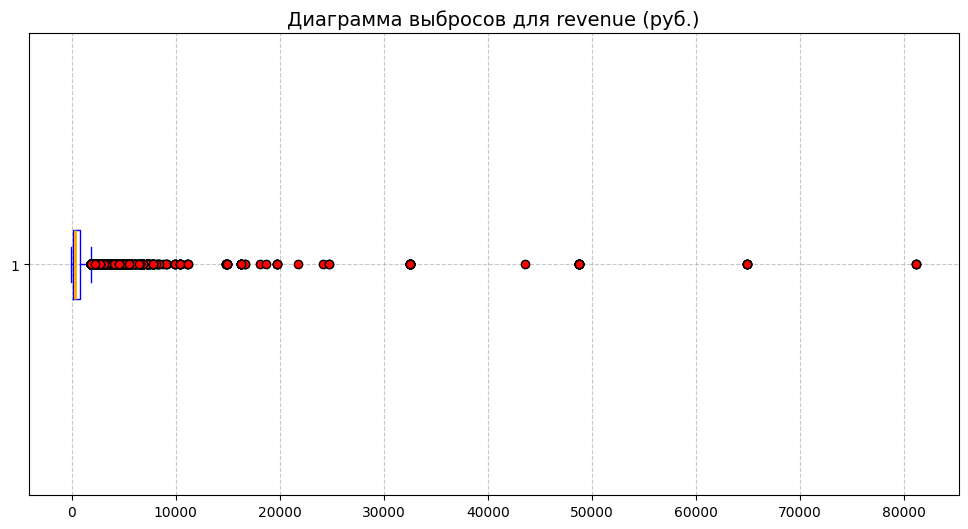

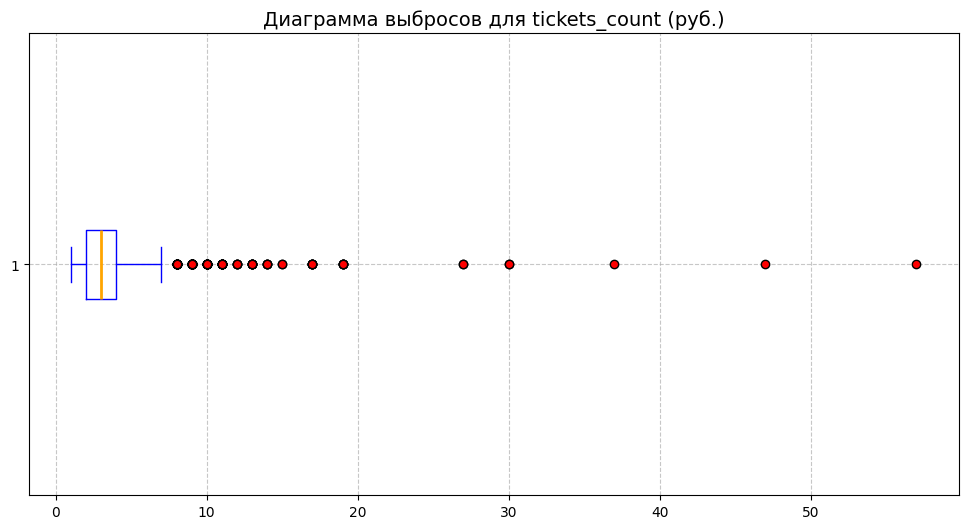

In [ ]:
columns = ['revenue', 'tickets_count']
for column in columns:
    plt.figure(figsize=(12, 6))
    plt.boxplot(
        df[df['currency_code'] == 'rub'][column],
        vert=False,
        flierprops=dict(markerfacecolor='red', marker='o', markersize=6),
        boxprops=dict(color='blue'),
        medianprops=dict(color='orange', linewidth=2),
        whiskerprops=dict(color='blue'),
        capprops=dict(color='blue')
    )
    plt.title(f'Диаграмма выбросов для {column} (руб.)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

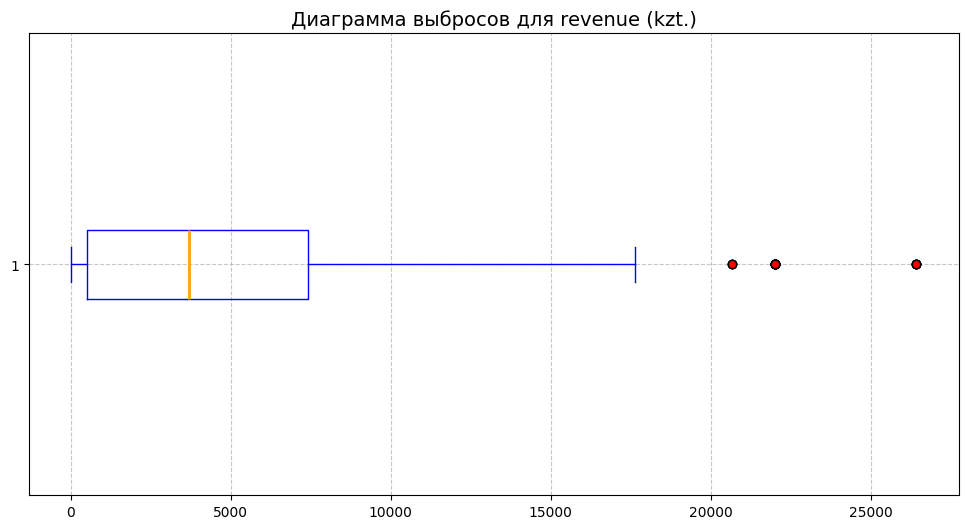

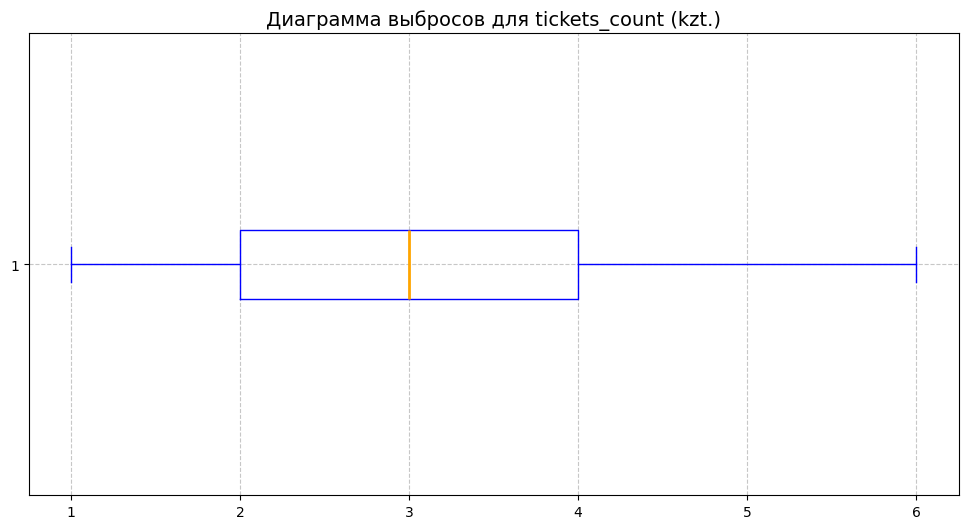

In [ ]:
columns = ['revenue', 'tickets_count']
for column in columns:
    plt.figure(figsize=(12, 6))
    plt.boxplot(
        df[df['currency_code'] == 'kzt'][column],
        vert=False,
        flierprops=dict(markerfacecolor='red', marker='o', markersize=6),
        boxprops=dict(color='blue'),
        medianprops=dict(color='orange', linewidth=2),
        whiskerprops=dict(color='blue'),
        capprops=dict(color='blue')
    )
    plt.title(f'Диаграмма выбросов для {column} (kzt.)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

- Показатель выручки российской валюты имеет значительное количество выбросов, что сказывается на нормальности распределения данных
- Количество проданных билетов так же содержит отдельные экстремальные значения, хотя их количество значительно меньше
- Для приближения данных к более нормальному распределению необходимо устранить выбросы, фильтруя значения по 99-перцентилю для разных валют
- В случае с казахской валютой ситуация более сбалансированная: для показателя выручки обнаружено всего три выброса, а по числу проданных билетов выбросов не зафиксировано

In [ ]:
perc_99_revenue_rub = df[df['currency_code'] == 'rub']['revenue'].quantile(0.99)
perc_99_revenue_kzt = df[df['currency_code'] == 'kzt']['revenue'].quantile(0.99)
perc_99_tickets = df['tickets_count'].quantile(0.99)
filtration = (
    ((df['currency_code'] == 'rub') & (df['revenue'] <= perc_99_revenue_rub)) |
    ((df['currency_code'] == 'kzt') & (df['revenue'] <= perc_99_revenue_kzt))) & (df['tickets_count'] <= perc_99_tickets)
df = df[filtration]

После устранения выбросов следует вновь построить диаграмму для оценки изменений в распределении данных и убедиться, как фильтрация повлияла на нормальность распределения

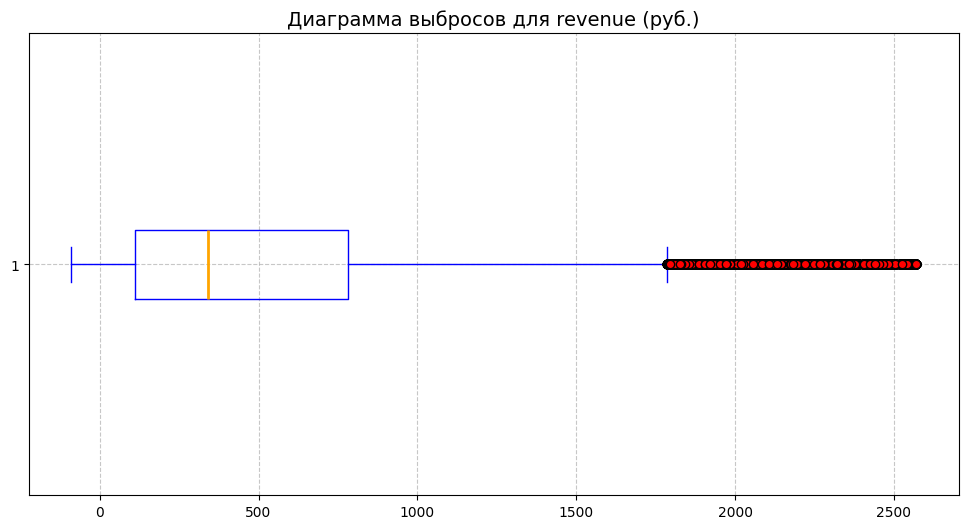

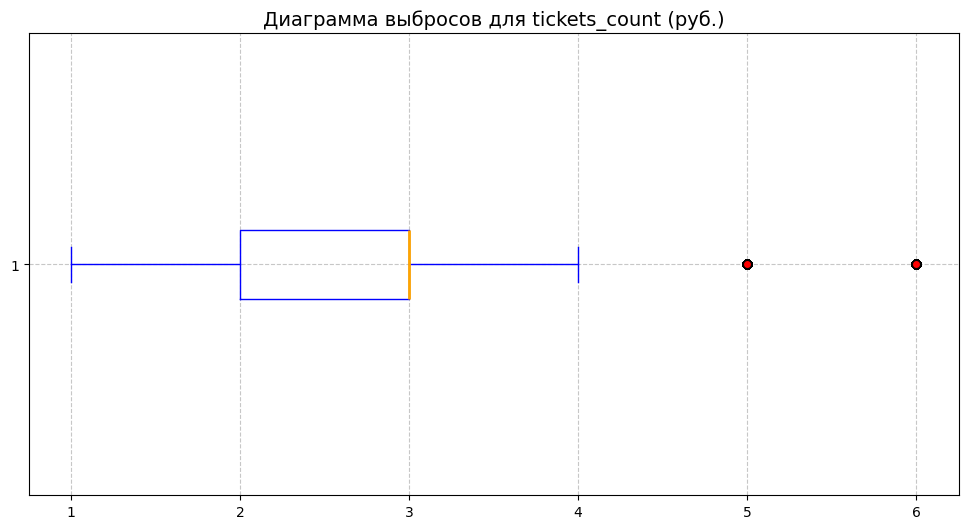

In [ ]:
columns = ['revenue', 'tickets_count']
for column in columns:
    plt.figure(figsize=(12, 6))
    plt.boxplot(
        df[df['currency_code'] == 'rub'][column],
        vert=False,
        flierprops=dict(markerfacecolor='red', marker='o', markersize=6),
        boxprops=dict(color='blue'),
        medianprops=dict(color='orange', linewidth=2),
        whiskerprops=dict(color='blue'),
        capprops=dict(color='blue')
    )
    plt.title(f'Диаграмма выбросов для {column} (руб.)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

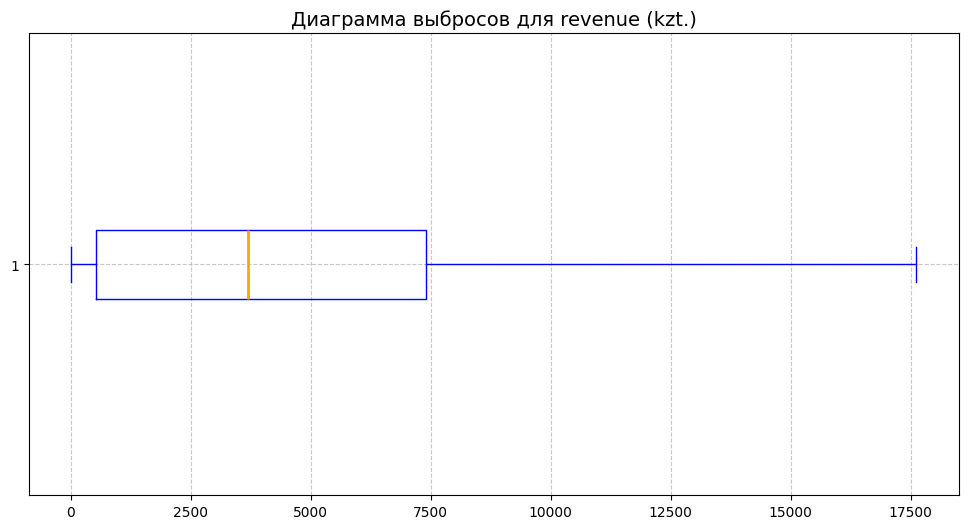

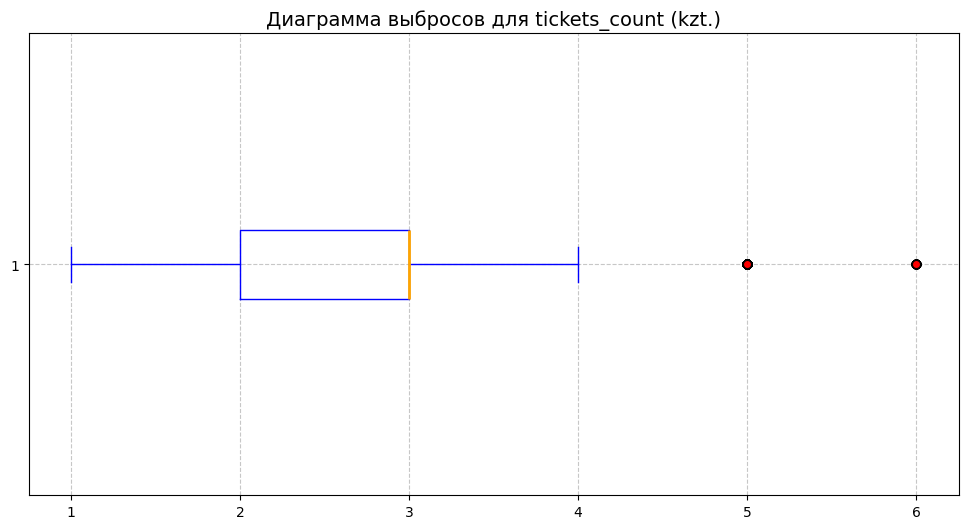

In [ ]:
columns = ['revenue', 'tickets_count']
for column in columns:
    plt.figure(figsize=(12, 6))
    plt.boxplot(
        df[df['currency_code'] == 'kzt'][column],
        vert=False,
        flierprops=dict(markerfacecolor='red', marker='o', markersize=6),
        boxprops=dict(color='blue'),
        medianprops=dict(color='orange', linewidth=2),
        whiskerprops=dict(color='blue'),
        capprops=dict(color='blue')
    )
    plt.title(f'Диаграмма выбросов для {column} (kzt.)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

Показатели приобрели более стабильный вид, этого достаточно для того чтобы продолжить работу с данными

### 2.3. Проверка данных на явные и неявные дубликаты

In [ ]:
print("Количество явных дубликатов")
print(df.duplicated().sum())
print("Количество неявных дубликатов")
print(df.duplicated(subset = ['user_id', 'created_dt_msk', 'created_ts_msk', 'event_id', 'cinema_circuit',
                              'age_limit', 'currency_code', 'device_type_canonical', 'revenue', 'service_name',
                              'tickets_count', 'total', 'days_since_prev', 'event_name', 'event_type_description',
                              'event_type_main', 'organizers', 'region_name', 'city_name', 'city_id', 'venue_id',
                              'venue_name', 'venue_address']).sum())
# Удаляем неявные дубликаты
df = df.drop_duplicates(subset=['user_id', 'created_dt_msk', 'created_ts_msk', 'event_id', 'cinema_circuit',
                              'age_limit', 'currency_code', 'device_type_canonical', 'revenue', 'service_name',
                              'tickets_count', 'total', 'days_since_prev', 'event_name', 'event_type_description',
                              'event_type_main', 'organizers', 'region_name', 'city_name', 'city_id', 'venue_id',
                              'venue_name', 'venue_address'])
print("Количество явных и неявных дубликатов после обработки")
print(df.duplicated().sum())

Количество явных дубликатов
0
Количество неявных дубликатов
30
Количество явных и неявных дубликатов после обработки
0


### 2.4. Преобразование необходимых типов данных

In [ ]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 287572 entries, 0 to 290610
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                287572 non-null  int64  
 1   user_id                 287572 non-null  object 
 2   created_dt_msk          287572 non-null  object 
 3   created_ts_msk          287572 non-null  object 
 4   event_id                287572 non-null  int64  
 5   cinema_circuit          287572 non-null  object 
 6   age_limit               287572 non-null  int64  
 7   currency_code           287572 non-null  object 
 8   device_type_canonical   287572 non-null  object 
 9   revenue                 287572 non-null  float64
 10  service_name            287572 non-null  object 
 11  tickets_count           287572 non-null  int64  
 12  total                   287572 non-null  float64
 13  days_since_prev         265871 non-null  float64
 14  event_name              2

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213,2941,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4"
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213,4507,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6"
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2,3574,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8"
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240,1896,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8"


В преобразовании типов нуждаются следующие столбцы:
 - `created_dt_msk` с object на datetime64
 - `created_ts_msk` с object на datetime64

In [ ]:
df['created_dt_msk'] = pd.to_datetime(df['created_dt_msk'], format='%Y-%m-%d')
df['created_ts_msk'] = pd.to_datetime(df['created_ts_msk'], format='%Y-%m-%d %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 287572 entries, 0 to 290610
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                287572 non-null  int64         
 1   user_id                 287572 non-null  object        
 2   created_dt_msk          287572 non-null  datetime64[ns]
 3   created_ts_msk          287572 non-null  datetime64[ns]
 4   event_id                287572 non-null  int64         
 5   cinema_circuit          287572 non-null  object        
 6   age_limit               287572 non-null  int64         
 7   currency_code           287572 non-null  object        
 8   device_type_canonical   287572 non-null  object        
 9   revenue                 287572 non-null  float64       
 10  service_name            287572 non-null  object        
 11  tickets_count           287572 non-null  int64         
 12  total                   287572 non-

In [ ]:
# Расмотрим так же таблицу tenge_df, которая хранит информацию о курсах валют
tenge_df.info()
tenge_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


В этой таблице требуется преобразовать только столбец `data` в более подходящий тип datetime64

In [ ]:
tenge_df['data'] = pd.to_datetime(tenge_df['data'], format = '%Y-%m-%d')
tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    int64         
 2   curs     357 non-null    float64       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.3+ KB


Данные успешно преобразованы, переходим к следующему шагу, к созданию дополнительных столбцов

### 2.5. Создание дополнительных столбцов
       

Создадим несколько новых столбцов а именно:
- revenue_rub — Выручка с заказа в российских рублях
- one_ticket_revenue_rub — Выручка с продажи одного билета на мероприятие
- month — Месяц оформления заказа
- season — Столбец с информацией о сезонности, включая такие категории, как лето, осень, зима и весна

In [ ]:
# Для создания нового столбца `revenue_rub` потребуется присоединить таблицу `tenge_df` для корректного расчета курса валюты
df = pd.merge(df, tenge_df, left_on = 'created_dt_msk', right_on = 'data', how = 'inner')

In [ ]:
# Расчет актуального курса revenue_rub
def rub_kzt(row):
    if row['currency_code'] == 'rub':
        return row['revenue']
    else:
        return row['revenue'] * row['curs'] / row['nominal']
df['revenue_rub'] = df.apply(rub_kzt, axis = 1)

In [ ]:
# Расчет выручки с продажи одного билета на мероприятие
df['one_ticket_revenue_rub'] = df['revenue_rub'] / df['tickets_count']

In [ ]:
# Расчет месяца оформления заказа
df['month'] = df['created_dt_msk'].dt.month

In [ ]:
# Расчет сезона с отображением 4 категорий (лето, осень, зима, весна)
def get_season(month):
    if month in [12, 1, 2]:
        return 'Зима'
    elif 3 <= month <= 5:
        return 'Весна'
    elif 6 <= month <= 8:
        return 'Лето'
    else:
        return 'Осень'
df['season'] = df['month'].apply(get_season)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287572 entries, 0 to 287571
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                287572 non-null  int64         
 1   user_id                 287572 non-null  object        
 2   created_dt_msk          287572 non-null  datetime64[ns]
 3   created_ts_msk          287572 non-null  datetime64[ns]
 4   event_id                287572 non-null  int64         
 5   cinema_circuit          287572 non-null  object        
 6   age_limit               287572 non-null  int64         
 7   currency_code           287572 non-null  object        
 8   device_type_canonical   287572 non-null  object        
 9   revenue                 287572 non-null  float64       
 10  service_name            287572 non-null  object        
 11  tickets_count           287572 non-null  int64         
 12  total                   287572

Предобработка данных завершена:

- В исходных данных были загружены три датафрейма: `order_df`, `event_df` и `tenge_df`. Позже эти таблицы были объединены в один общий датафрейм `df`.
- Пропуски в данных обнаружены только в показателе первой покупки пользователя, остальные пропуски отсутствовали
- Явных дубликатах не выявлено, однако были найдены и устранены неявные дубликаты
- Анализ категорийных столбцов показал отсутствие ошибок и несогласованностей в уникальных значениях
- Были выявлены значительные выбросы, отрицательно влияющие на распределение данных, после фильтрации по 99-перцентилю данные приобрели более стабильный и нормализованный вид
- Типы данных для некоторых столбцов были приведены к более подходящему формату, что обеспечило корректную работу с даннымы
- Для расширенного аналитического анализа были добавлены новые показатели:
  - revenue_rub — выручка с заказа в российских рублях;
  - one_ticket_revenue_rub — выручка с продажи одного билета;
  - month — месяц оформления заказа;
  - season — категория, отражающая сезонность (лето, осень, зима, весна)

## 3. Исследовательский анализ данных

###3.1. Анализ распределения заказов по сегментам и их сезонные изменения


####3.1.1 Временная активность покупателей

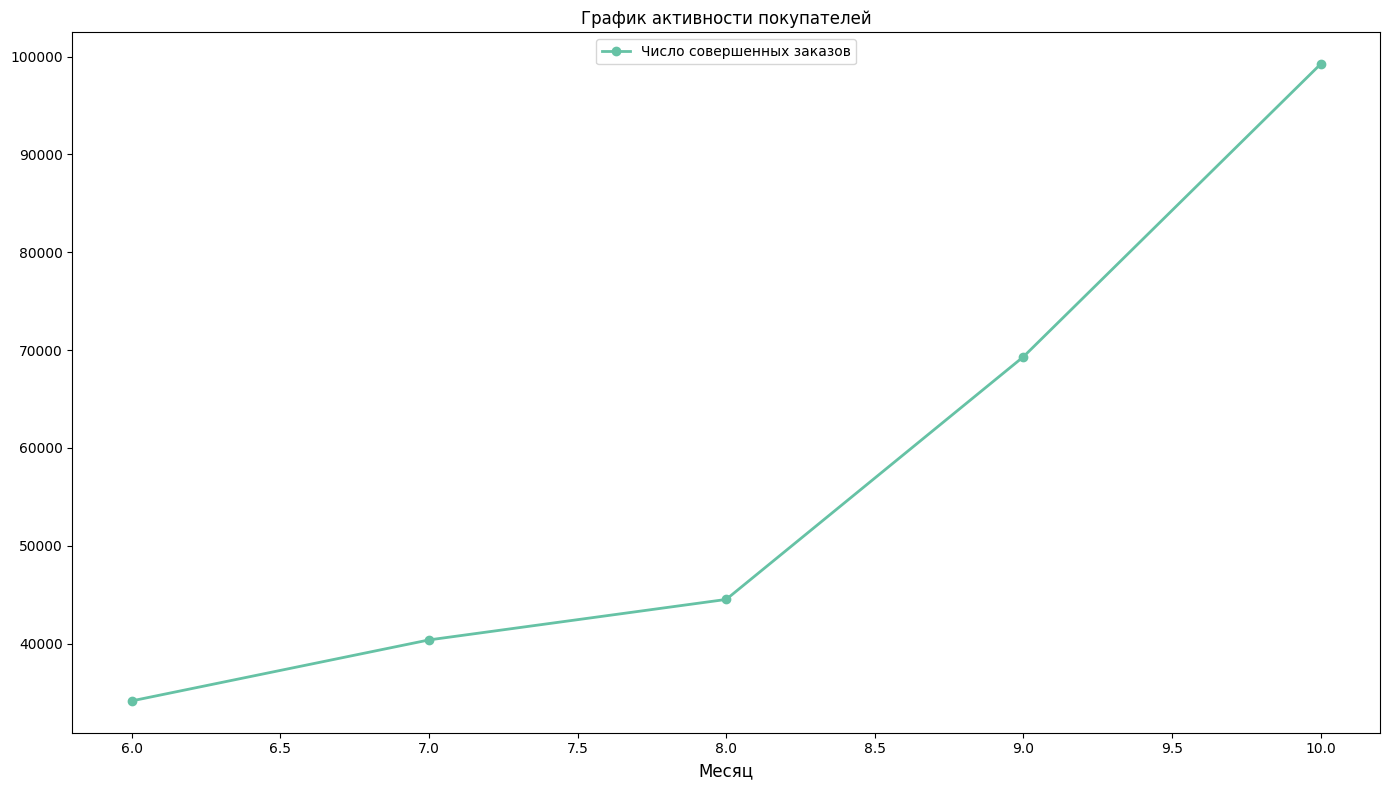

In [ ]:
# Рассмотрим количество заказов в каждом месяце
df_month_counts_order = df.groupby('month')['order_id'].nunique()
plt.figure(figsize=(14,8))
ax = plt.gca()
color_palette = plt.get_cmap('Set2')
ax.plot(df_month_counts_order.index, df_month_counts_order.values, label='Число совершенных заказов',
        marker='o', color=color_palette(0), linewidth=2)
plt.xlabel('Месяц', fontsize=12)
plt.title('График активности покупателей')
plt.legend(loc = 'upper center')
plt.tight_layout()
plt.show()

В целом с июня фиксируется рост числа заказов, причем наиболее значительный прирост наблюдается с сентября, можно отметить внезапное и существенное увеличение активности покупателей в начале осеннего сезона

####3.1.2. Сравнение распределения заказов в разрезе двух периодов (Лето и осень)

Рассмотрим сравнение по разным категориям, а именно
- Тип мероприятия
- Тип устройства
- Возрастной рейтинг

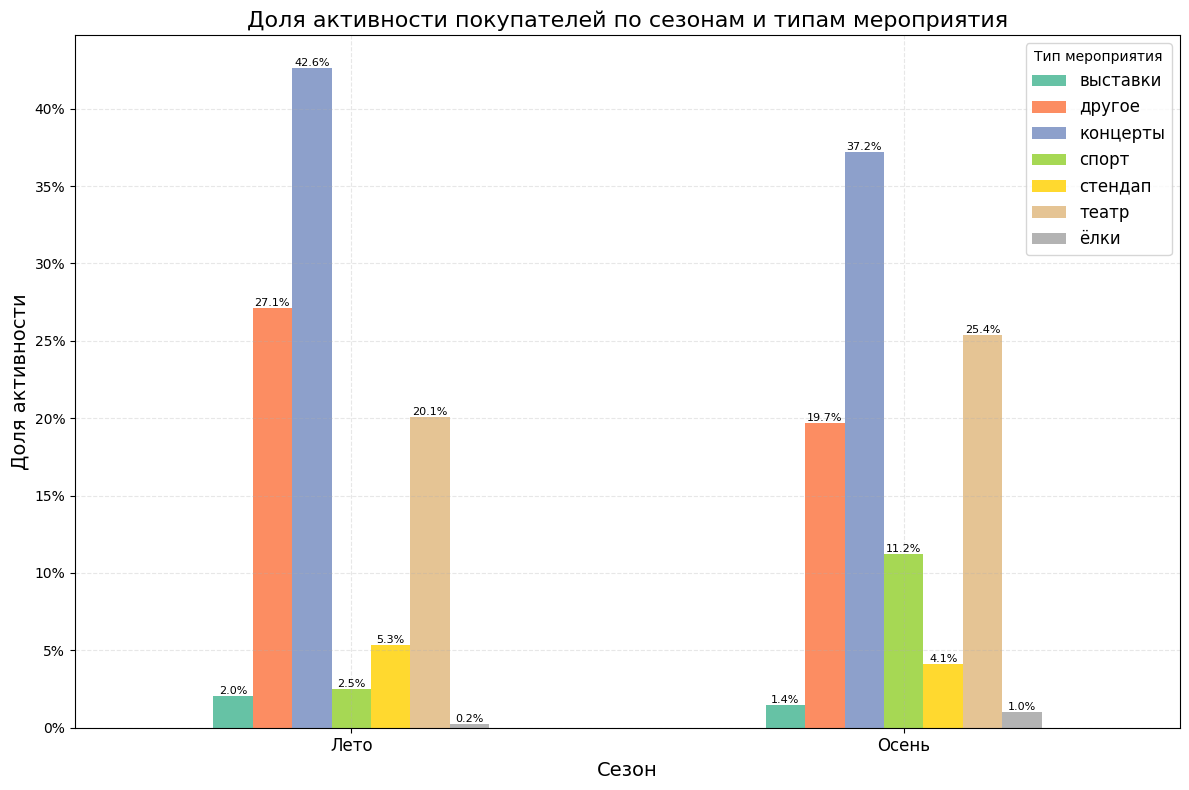

In [ ]:
df_season_group_event = df.groupby(['season', 'event_type_main'])['order_id'].nunique() / df.groupby('season')['order_id'].nunique() * 100
ax = df_season_group_event.unstack().plot(
    kind='bar',
    figsize=(12,8),
    colormap='Set2')
ax.bar_label(ax.containers[0], fmt='%.1f%%', fontsize=8)
ax.bar_label(ax.containers[1], fmt='%.1f%%', fontsize=8)
ax.bar_label(ax.containers[2], fmt='%.1f%%', fontsize=8)
ax.bar_label(ax.containers[3], fmt='%.1f%%', fontsize=8)
ax.bar_label(ax.containers[4], fmt='%.1f%%', fontsize=8)
ax.bar_label(ax.containers[5], fmt='%.1f%%', fontsize=8)
ax.bar_label(ax.containers[6], fmt='%.1f%%', fontsize=8)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(round(x))}%'))
plt.xlabel('Сезон', fontsize=14)
plt.ylabel('Доля активности', fontsize=14)
plt.title('Доля активности покупателей по сезонам и типам мероприятия', fontsize=16)
plt.legend(title='Тип мероприятия', fontsize=12)
plt.xticks(rotation=0, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Здесь мы видим увеличившийся интерес к спортивным мероприятиям и театральным премьерам, в то же время наблюдается снижение популярности концертов и других категорий событий. Среди «других» мероприятий находятся выставки, музыкальные спектакли, мероприятия Академии искусств, арт-ивенты и т.д — несмотря на это, они остаются одними из самых популярных категорий.

Далее рассмотрим распределение активности пользователей по типу устройства, так же в разрезе двух периодов.

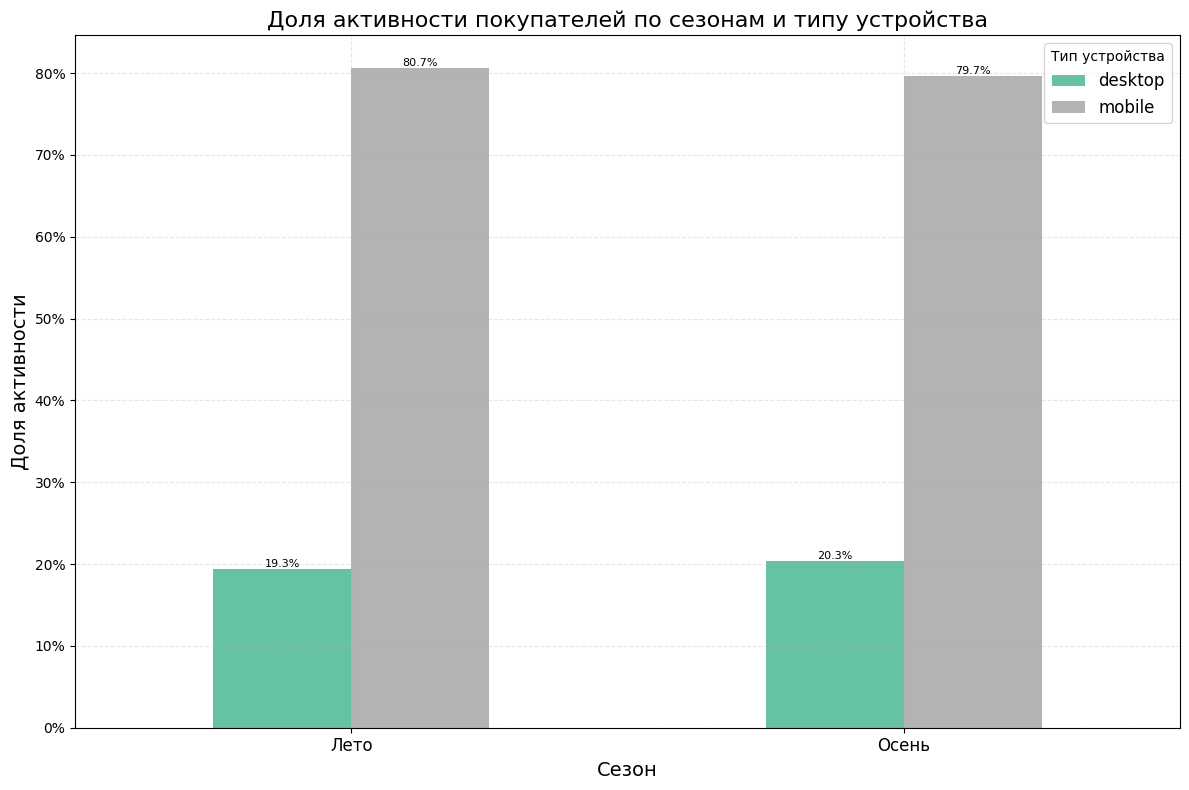

In [ ]:
df_season_group_device = df.groupby(['season', 'device_type_canonical'])['order_id'].nunique() / df.groupby('season')['order_id'].nunique() * 100
ax = df_season_group_device.unstack().plot(
    kind='bar',
    figsize=(12,8),
    colormap='Set2')
ax.bar_label(ax.containers[0], fmt='%.1f%%', fontsize=8)
ax.bar_label(ax.containers[1], fmt='%.1f%%', fontsize=8)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(round(x))}%'))
plt.xlabel('Сезон', fontsize=14)
plt.ylabel('Доля активности', fontsize=14)
plt.title('Доля активности покупателей по сезонам и типу устройства', fontsize=16)
plt.legend(title='Тип устройства', fontsize=12)
plt.xticks(rotation=0, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Самым популярным устройством для заказа билетов являются мобильные телефоны, это можно обьяснить удобоством и простотой, ведь телефон всегда под рукой и билеты можно заказать мгновенно и без лишних усилий

Так же доля использования разных устройств со временем не изменилась  
Далее проанализируем возрастную категорию мероприятий в разрезе двух сезонов

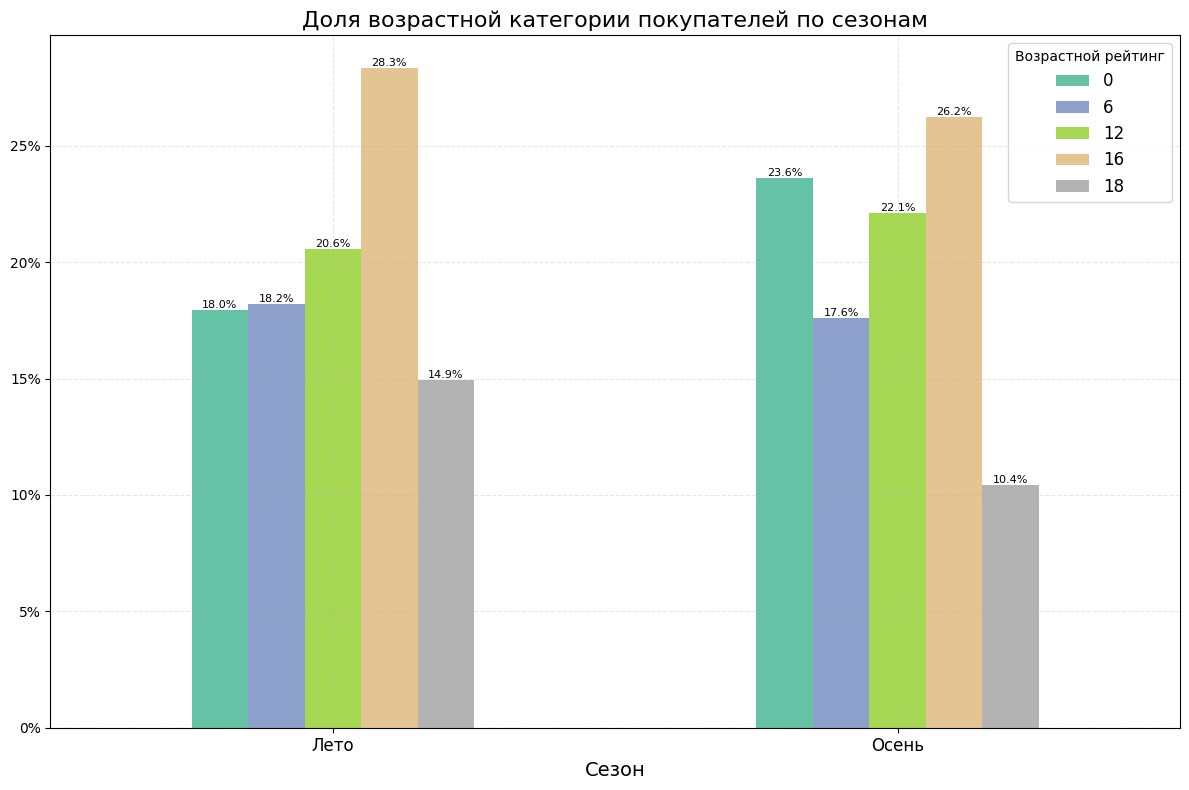

In [ ]:
df_season_group = df.groupby('season')['age_limit'].value_counts()
df_season_group_1 = df_season_group.reset_index()
df_season_group_age = df_season_group / df_season_group_1.groupby('season')['count'].sum() * 100
ax = df_season_group_age.unstack().plot(
    kind='bar',
    figsize=(12,8),
    colormap='Set2')
ax.bar_label(ax.containers[0], fmt='%.1f%%', fontsize=8)
ax.bar_label(ax.containers[1], fmt='%.1f%%', fontsize=8)
ax.bar_label(ax.containers[2], fmt='%.1f%%', fontsize=8)
ax.bar_label(ax.containers[3], fmt='%.1f%%', fontsize=8)
ax.bar_label(ax.containers[4], fmt='%.1f%%', fontsize=8)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(round(x))}%'))
plt.xlabel('Сезон', fontsize=14)
plt.title('Доля возрастной категории покупателей по сезонам', fontsize=16)
plt.legend(title='Возрастной рейтинг', fontsize=12)
plt.xticks(rotation=0, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

На графике мы видим, что осенью особенно популярны стали детские мероприятия с неограниченным возрастным рейтингом 0 и с возрастной отметкой 12+

При этом, популярность взрослых мероприятий 18+ немного снизилась, это показывает растущий интерес к детским и семейным развлечениям

####3.1.3. Анализ выручки с продажи одного билета

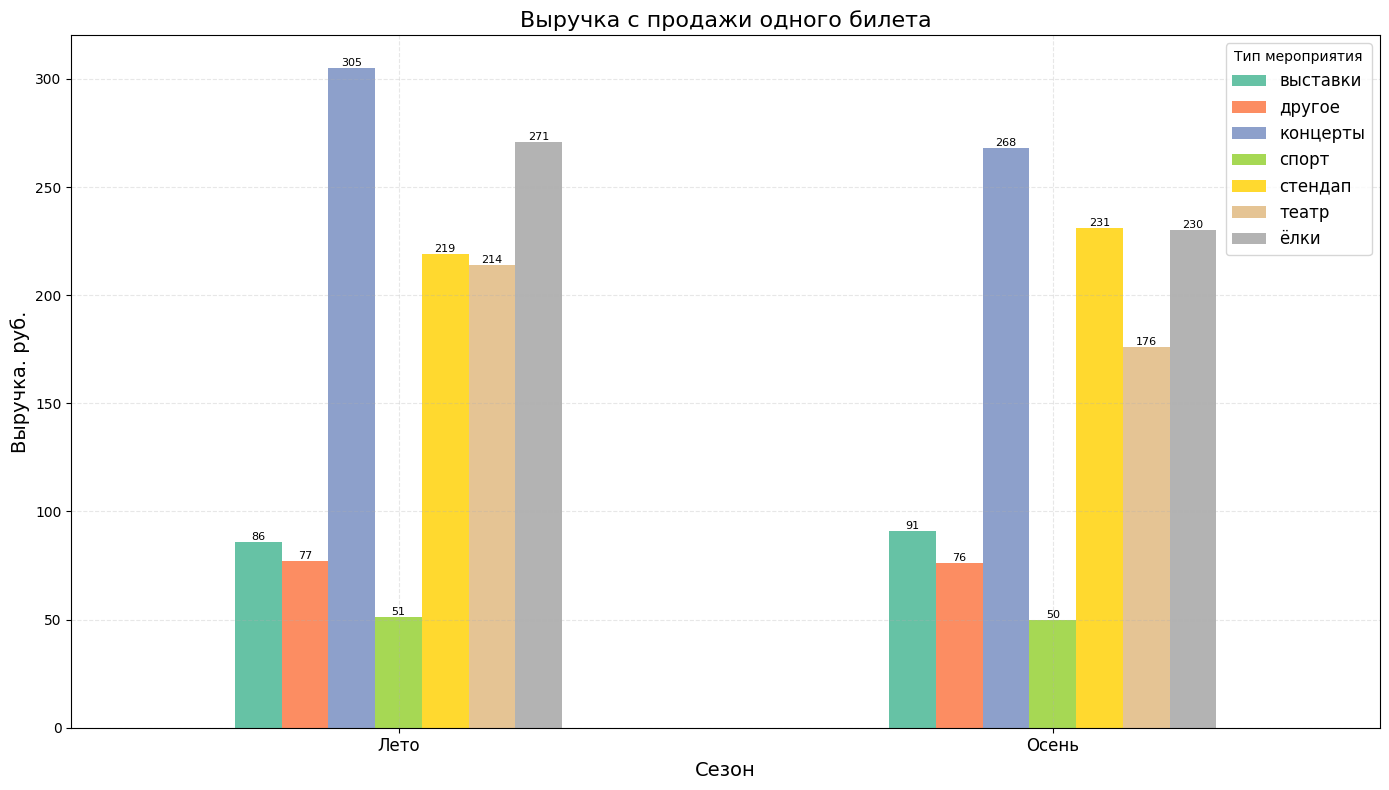

In [ ]:
df_group_mean = df.groupby(['season', 'event_type_main'])['one_ticket_revenue_rub'].mean().round()
ax = df_group_mean.unstack().plot(
    kind='bar',
    figsize=(14,8),
    colormap='Set2')
ax.bar_label(ax.containers[0], fontsize=8)
ax.bar_label(ax.containers[1], fontsize=8)
ax.bar_label(ax.containers[2], fontsize=8)
ax.bar_label(ax.containers[3], fontsize=8)
ax.bar_label(ax.containers[4], fontsize=8)
ax.bar_label(ax.containers[5], fontsize=8)
ax.bar_label(ax.containers[6], fontsize=8)
plt.xlabel('Сезон', fontsize=14)
plt.ylabel('Выручка. руб.', fontsize=14)
plt.title('Выручка с продажи одного билета', fontsize=16)
plt.legend(title='Тип мероприятия', fontsize=12, loc = 'upper right')
plt.xticks(rotation=0, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

В целом, средняя выручка с продажи одного билета постепенно снижалась практически во всех категориях мероприятий осенью, для более наглядного сравнения рассмотрим график относительных изменений, демонстрирующий соотношение осенней выручке по отношению к летней

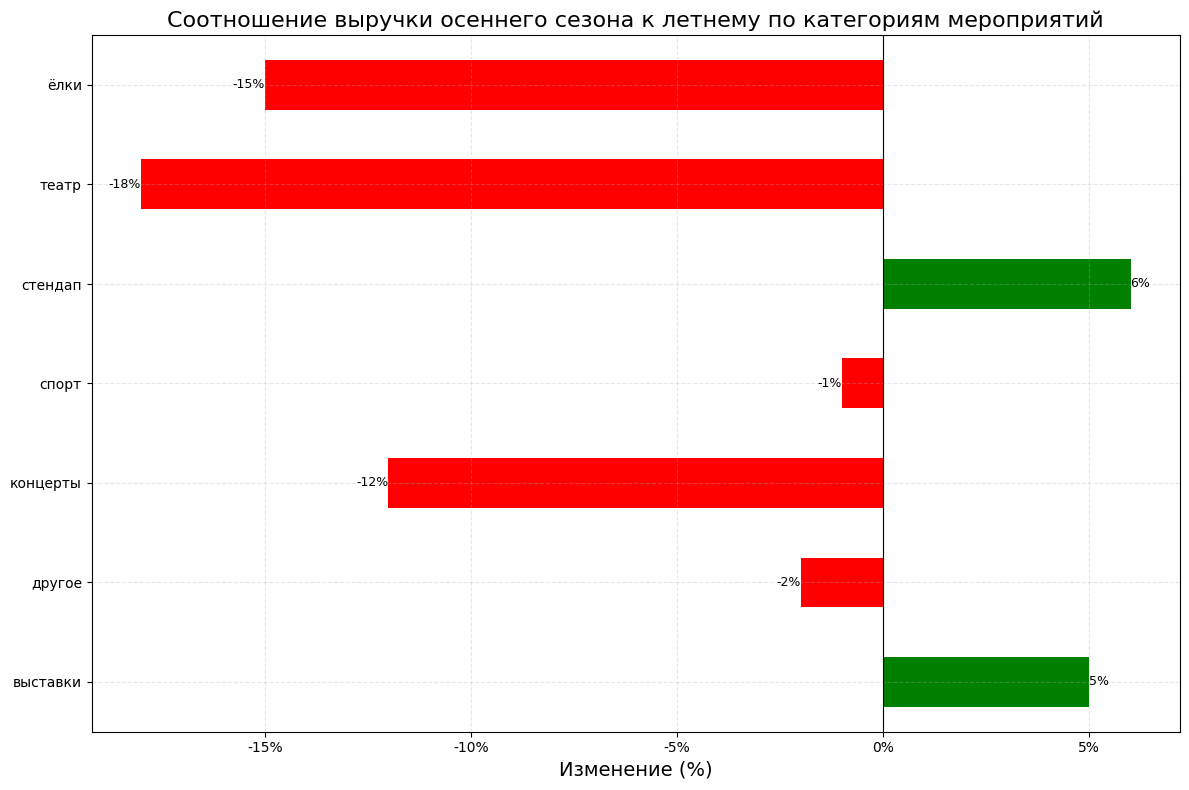

In [ ]:
df.groupby(['season', 'event_type_main'])['one_ticket_revenue_rub'].mean()
df_group_summer = df.query("season == 'Лето'").groupby(['season', 'event_type_main'])['one_ticket_revenue_rub'].mean().reset_index()
df_group_fall = df.query("season == 'Осень'").groupby(['season', 'event_type_main'])['one_ticket_revenue_rub'].mean().reset_index()
df_group_fall['share'] = round((df_group_fall.iloc[:,2] / df_group_summer.iloc[:,2] - 1),2) * 100
df_group_fall = df_group_fall.drop(['one_ticket_revenue_rub', 'season'], axis = 1)
df_share = df_group_fall.set_index('event_type_main')['share']
colors = ['green' if val > 0 else 'red' for val in df_share]
ax = df_share.plot(kind='barh', color=colors, figsize=(12,8))
ax.bar_label(ax.containers[0], fontsize=9, fmt='%.0f%%')
plt.axvline(0, color='black', linewidth=0.8)
plt.xlabel('Изменение (%)', fontsize=14)
ax.set_ylabel('')
plt.title('Соотношение выручки осеннего сезона к летнему по категориям мероприятий', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.3)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.0f}%'))
plt.tight_layout()
plt.show()

Лишь в двух категориях выручка осенью оказалась положительной - это стендапы и выставки, в остальных категориях мероприятий средняя выручка за один билет снизилась  

####Результаты сравнения активности пользователей в летний и осенний сезоны
- Осенью число заказов существенно увеличилось
- Концерты и театральные постановки остаются наиболее востребованными, при этом популярность театров и спортивных мероприятий значительно выросла
- Самым удобным устройством для покупки билетов по-прежнему является смартфон, благодаря своему удобству и доступности
- В осенний сезон особую популярность приобрели детские мероприятия с рейтингом 0+ и 12+, в то время как интерес к взрослым мероприятиям 18+ снизился
- Несмотря на рост количества заказов, средняя выручка с одного билета снизилась даже в самых популярных категориях, вероятно, на это повлияли низкие цены на билеты, в будущем стоит проработать ценовую стратегию для массовых мероприятий, чтобы сбалансировать спрос и доходность

###3.2. Осенняя активность пользователей

Проанализируем динамику изменений по дням для:
- общего числа заказов;
- количества активных пользователей DAU;
- среднего числа заказов на одного пользователя;
- средней стоимости одного билета.

####3.2.1.1. Общее число заказов по дням
    

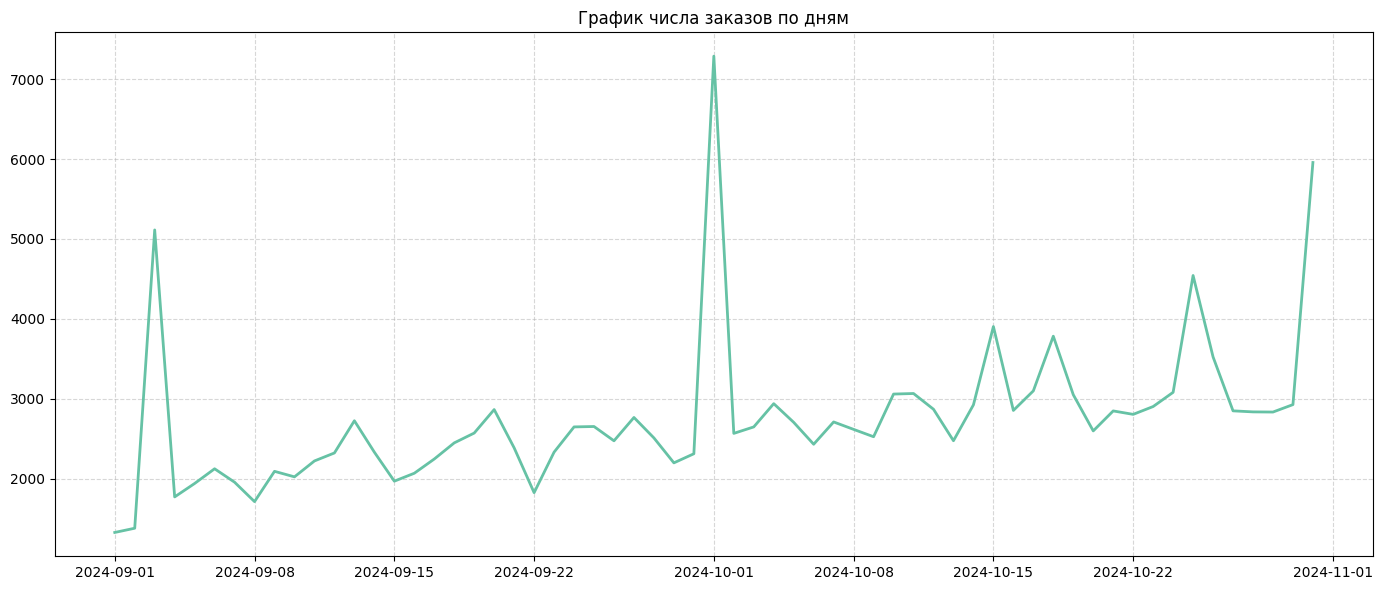

In [ ]:
df_fall = df.query("season == 'Осень'") # Создадим "осеннюю" таблицу
df_order_count = df_fall.groupby('data')['order_id'].nunique()
plt.figure(figsize=(14,6))
ax = plt.gca()
ax.plot(df_order_count.index, df_order_count.values, label='Среднее число заказов на одного пользователя', color= color_palette(0), linewidth=2)
plt.title('График числа заказов по дням')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Число заказов стабильно растет изо дня в день, имееются также резкие скачки продаж билетов, скорее всего это связано с массовыми популярными мероприятиями, такими как концерт или большой театр


####3.2.1.2. Количество активных пользователей DAU

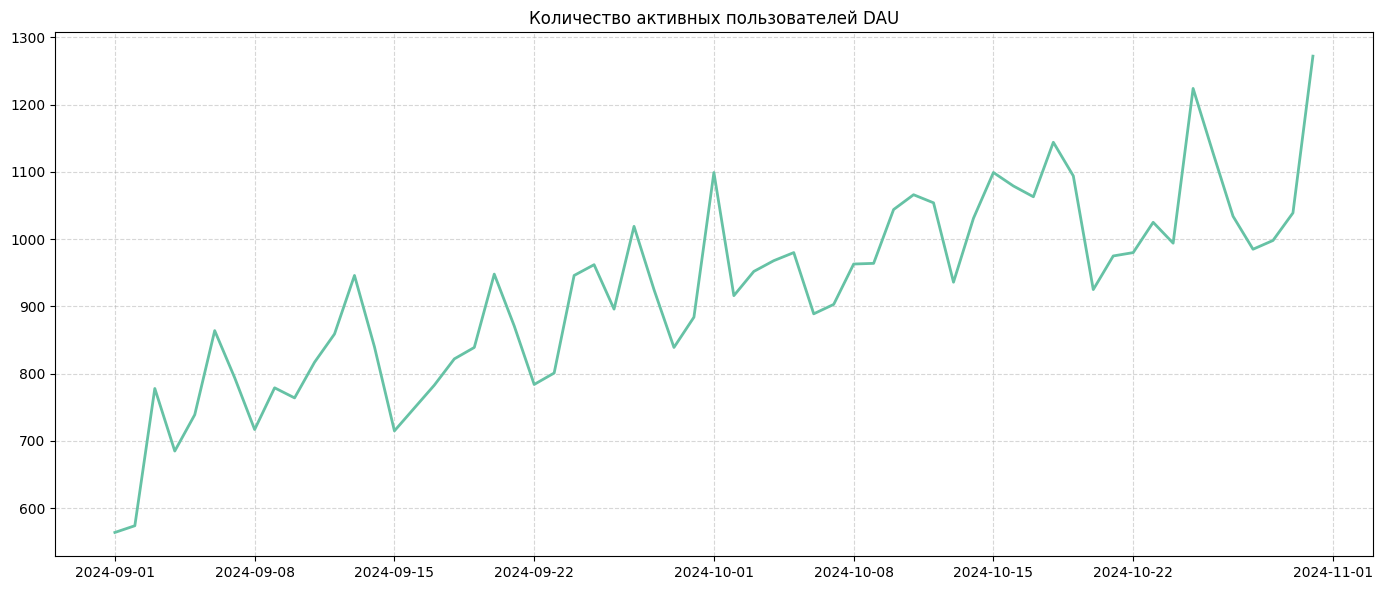

In [ ]:
df_user_count = df_fall.groupby('data')['user_id'].nunique()
plt.figure(figsize=(14,6))
ax = plt.gca()
ax.plot(df_user_count.index, df_user_count.values, label='DAU', color= color_palette(0), linewidth=2)
plt.title('Количество активных пользователей DAU')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Показатель DAU стабильно растет, то есть все больше людей начинают активно посещать разные мероприятия и события

Это положительный тренд, который указывает на высокую заинтересованность аудитории и расширение охвата, это открывает новые возможности для дальнейшего развития и усиления позиций на рынке

####3.2.1.3. Среднее число заказов на одного пользователя
    

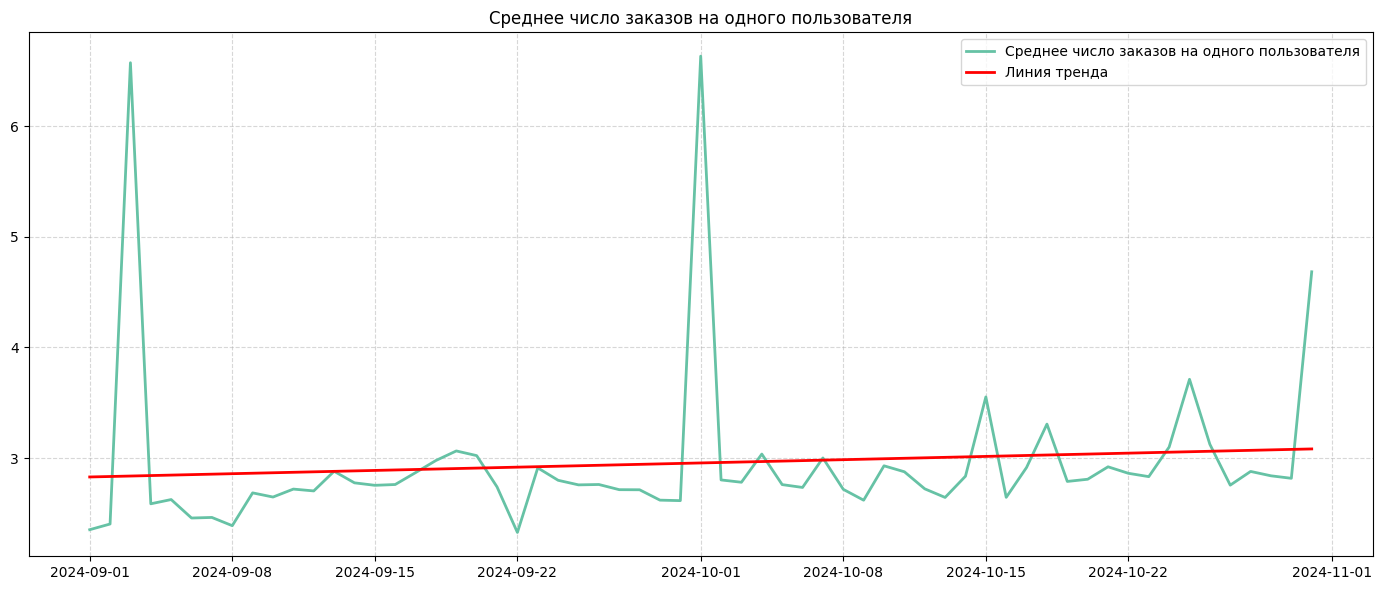

In [ ]:
mean_count = df_fall.groupby('data').agg({
                              'order_id': 'nunique',
                              'user_id' : 'nunique'})
mean_count_orders = mean_count.iloc[:, 0] / mean_count.iloc[:,1]
mean_count_orders = mean_count_orders.rename('mean_count')
plt.figure(figsize=(14,6))
ax = plt.gca()
ax.plot(mean_count_orders.index, mean_count_orders.values, label='Среднее число заказов на одного пользователя', color=color_palette(0), linewidth=2)
x = np.arange(len(mean_count_orders))
y = mean_count_orders.values
coeffs = np.polyfit(x, y, deg=1)
trend = np.poly1d(coeffs)
ax.plot(mean_count_orders.index, trend(x), color='red', linewidth=2, label='Линия тренда')
plt.title('Среднее число заказов на одного пользователя')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

На графике среднего количества заказов на одного пользователя мы замечаем резкие колебания активности, 3 сентября и 1 октября прошли самые масташтабные мероприятия, охватившие большую часть аудитории.

Чтобы понять, есть ли явная тенденция роста нашего показателя, была добавлена линия тренда. Она показывает, что показатель постепенно и незначительно увеличивается со временем

####3.2.1.4. Средняя стоимость одного билета

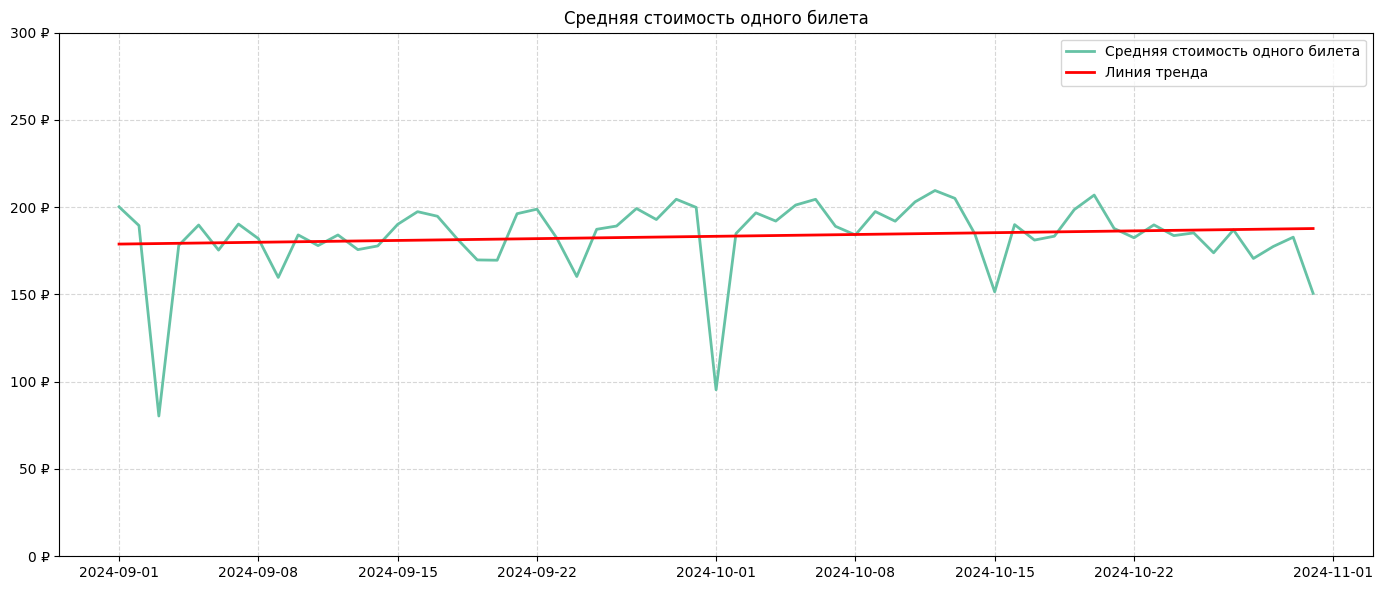

In [ ]:
mean_revenue_one_ticket = round(df_fall.groupby('data')['one_ticket_revenue_rub'].mean(),2)
plt.figure(figsize=(14,6))
ax = plt.gca()
ax.plot(mean_revenue_one_ticket.index, mean_revenue_one_ticket.values, label='Средняя стоимость одного билета', color= color_palette(0), linewidth=2)
formatter = ticker.FuncFormatter(lambda x, pos: f'{int(x)} ₽')
ax.yaxis.set_major_formatter(formatter)
plt.ylim(0, 300)
plt.yticks(range(0, 301, 50))
x = np.arange(len(mean_revenue_one_ticket))
y = mean_revenue_one_ticket.values
coeffs = np.polyfit(x, y, deg=1)
trend = np.poly1d(coeffs)
ax.plot(mean_revenue_one_ticket.index, trend(x), color='red', linewidth=2, label='Линия тренда')
plt.title('Средняя стоимость одного билета')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Средняя стоимость билетов держится умеренно и со временнем растет, это видно благодаря линии тренда, на графике также видны периодические скачки низких цен, связанные с масштабными мероприятиями в начале сентября и октября.

Возможно, для этих мероприятий проводились масштабные маркетинговые кампании, с использованием специальных предложений и скидок

####3.2.2. Недельная цикличность

Рассмотрим пользовательскую активность в каждый день недели

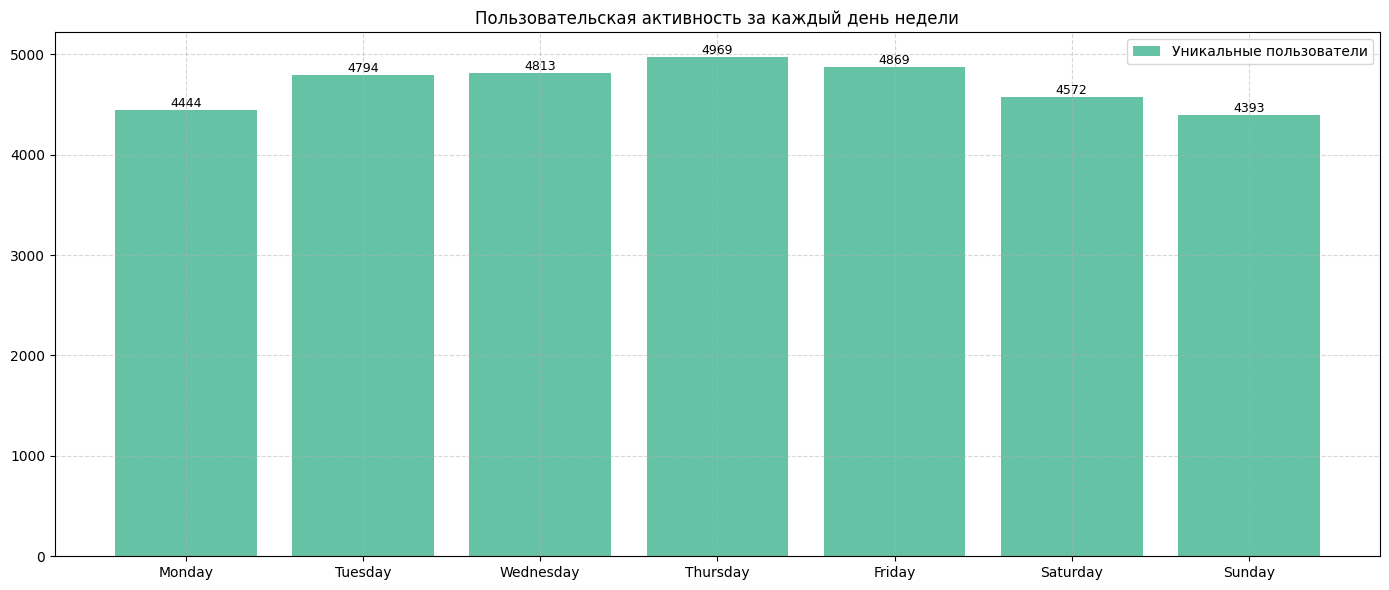

In [ ]:
df_fall['day_of_week'] = df_fall['data'].dt.strftime('%A')
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_fall['day_of_week'] = pd.Categorical(df_fall['day_of_week'], categories= days, ordered=True)
week_df_group = df_fall.groupby('day_of_week')['user_id'].nunique().sort_index()
plt.figure(figsize = (14,6))
ax = plt.gca()
ax.bar(week_df_group.index, week_df_group.values, label = 'Уникальные пользователи', color = color_palette(0), linewidth=2)
ax.bar_label(ax.containers[0], fontsize=9)
plt.title('Пользовательская активность за каждый день недели')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()

Ближе к середине недели наблюдается самая высокая активность у пользователей, однако в выходные, активность ниже чем ожидалось, из этого можно сделать вывод:
что на выходных, особенно в воскресенье, пользователи предпочитают больше уделять время семейным делам и домашним заботам, оставляя посещение мероприятий на будние дни

###3.3. Популярные события и партнёры

Рассмотрим распределение событий по регионам и партнерам и выделим лидеров по выручке


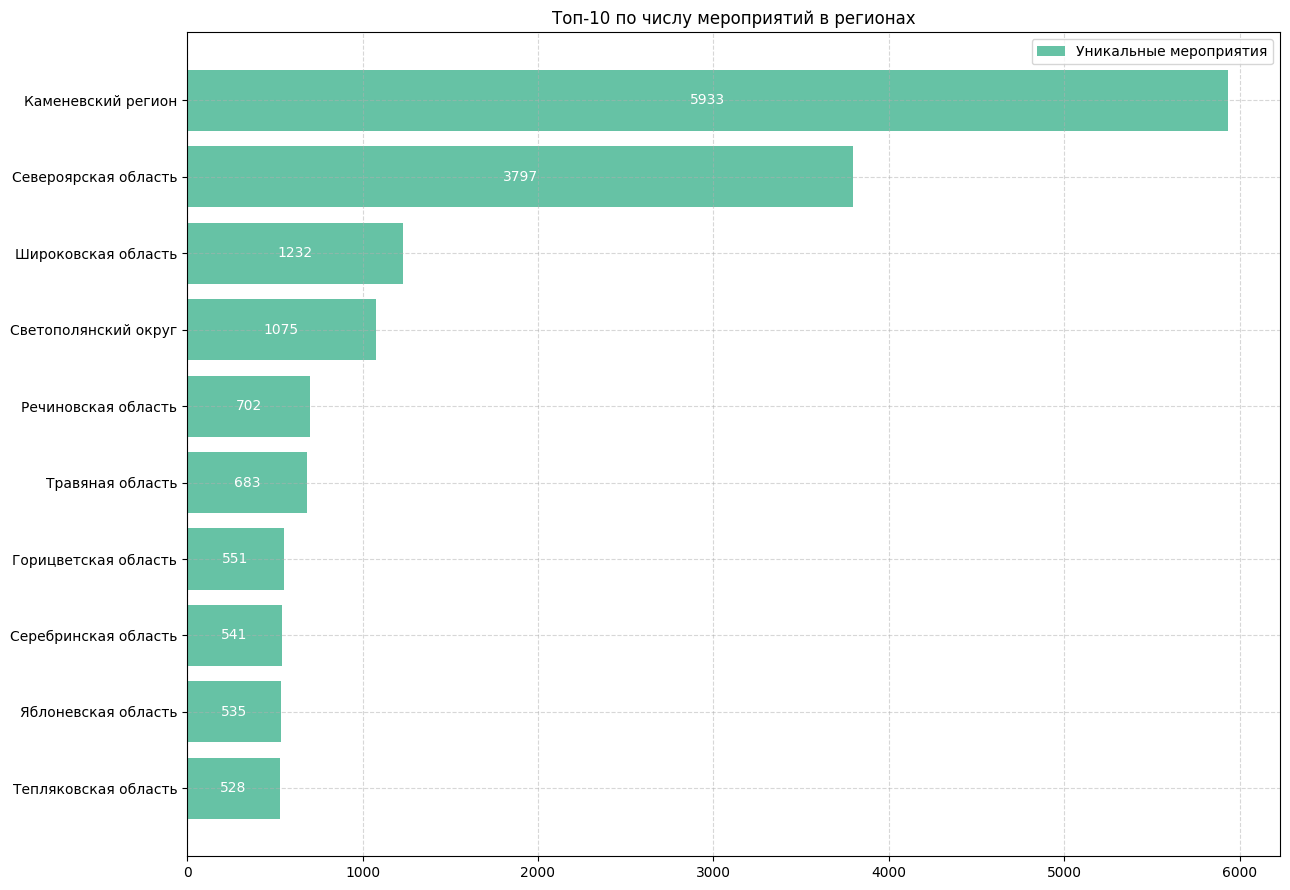

In [ ]:
# Топ-10 по количеству мероприятий в разрезе регионов
df_region_group = df.groupby('region_name')['event_id'].nunique().sort_values(ascending=False).head(10)
plt.figure(figsize = (13,9))
ax = plt.gca()
ax.barh(df_region_group.index, df_region_group.values, label = 'Уникальные мероприятия', color = color_palette(0), linewidth=2)
plt.title('Топ-10 по числу мероприятий в регионах')
plt.grid(True, linestyle='--', alpha=0.5)
ax.bar_label(ax.containers[0], label_type='center', fontsize=10, color='white')
ax.invert_yaxis()
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Из представленной диаграммы видно, что два региона заметно выделяются, значительно превосходя остальных по уровню активности. Возможно, именно в этих регионах предлагается наиболее широкий ассортимент мероприятий, что привлекает большое количество посетителей и повышает их популярность по сравнению с другими регионами

Посмотрим на эту же динамику в относительном значении

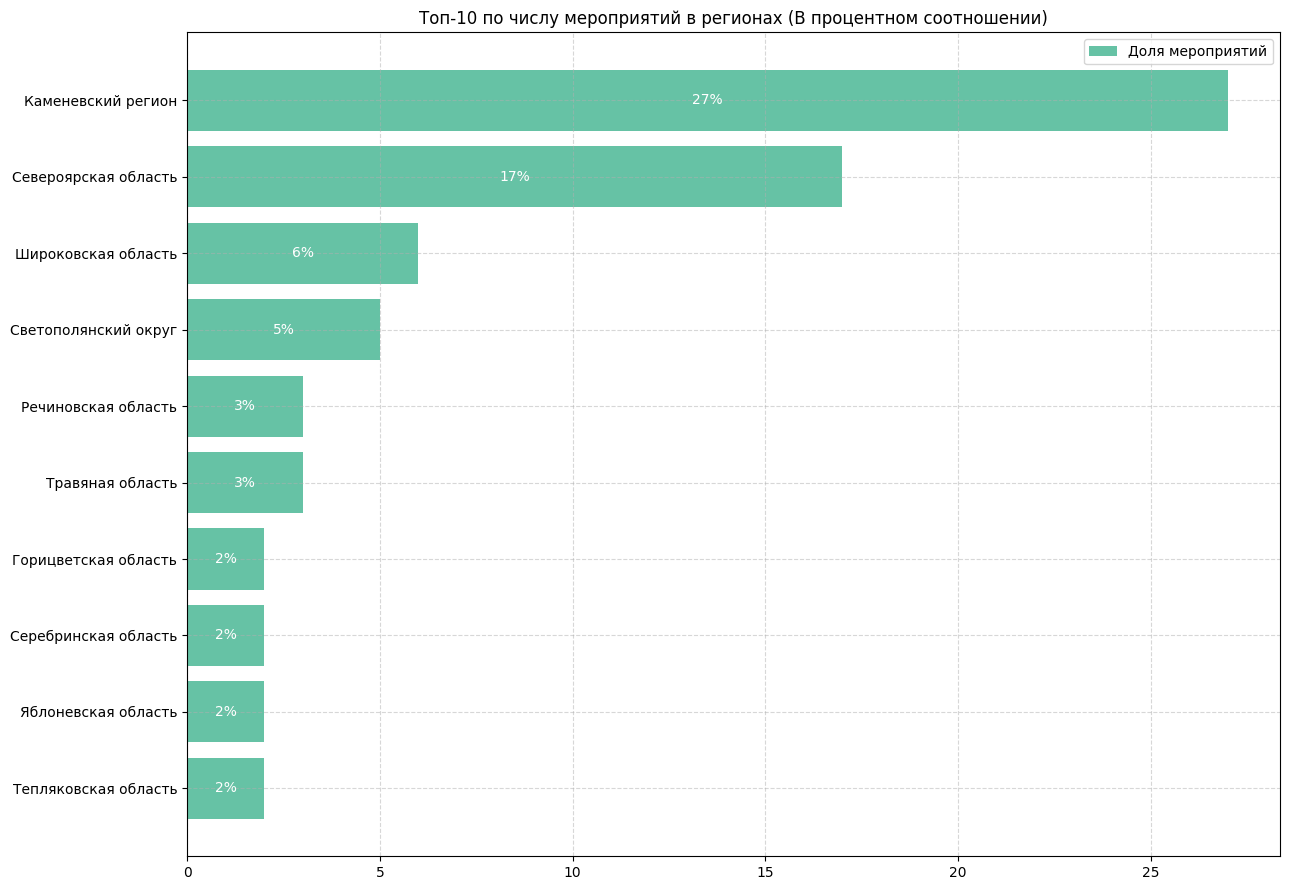

In [ ]:
df_share = df.groupby('region_name')['event_id'].nunique().sum()
df_region_group = round(df.groupby('region_name')['event_id'].nunique().sort_values(ascending=False).head(10) / df_share,2) * 100
plt.figure(figsize = (13,9))
ax = plt.gca()
ax.barh(df_region_group.index, df_region_group.values, label = 'Доля мероприятий', color = color_palette(0), linewidth=2)
plt.title('Топ-10 по числу мероприятий в регионах (В процентном соотношении)')
plt.grid(True, linestyle='--', alpha=0.5)
ax.bar_label(
    ax.containers[0],
    labels=df_region_group.values.round(0).astype(int).astype(str) + '%',
    label_type='center', fontsize=10, color='white')
ax.invert_yaxis()
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


В относительном выражении видно, что первые два региона занимают более 44% всех мероприятий, проводимых в различных регионах, это делает их самыми популярными среди всех остальных регионов

Теперь посмотрим на общую картину распределения, предварительно отфильтруем лидирующие регионы: «Каменевский регион» и «Североярскую область»  


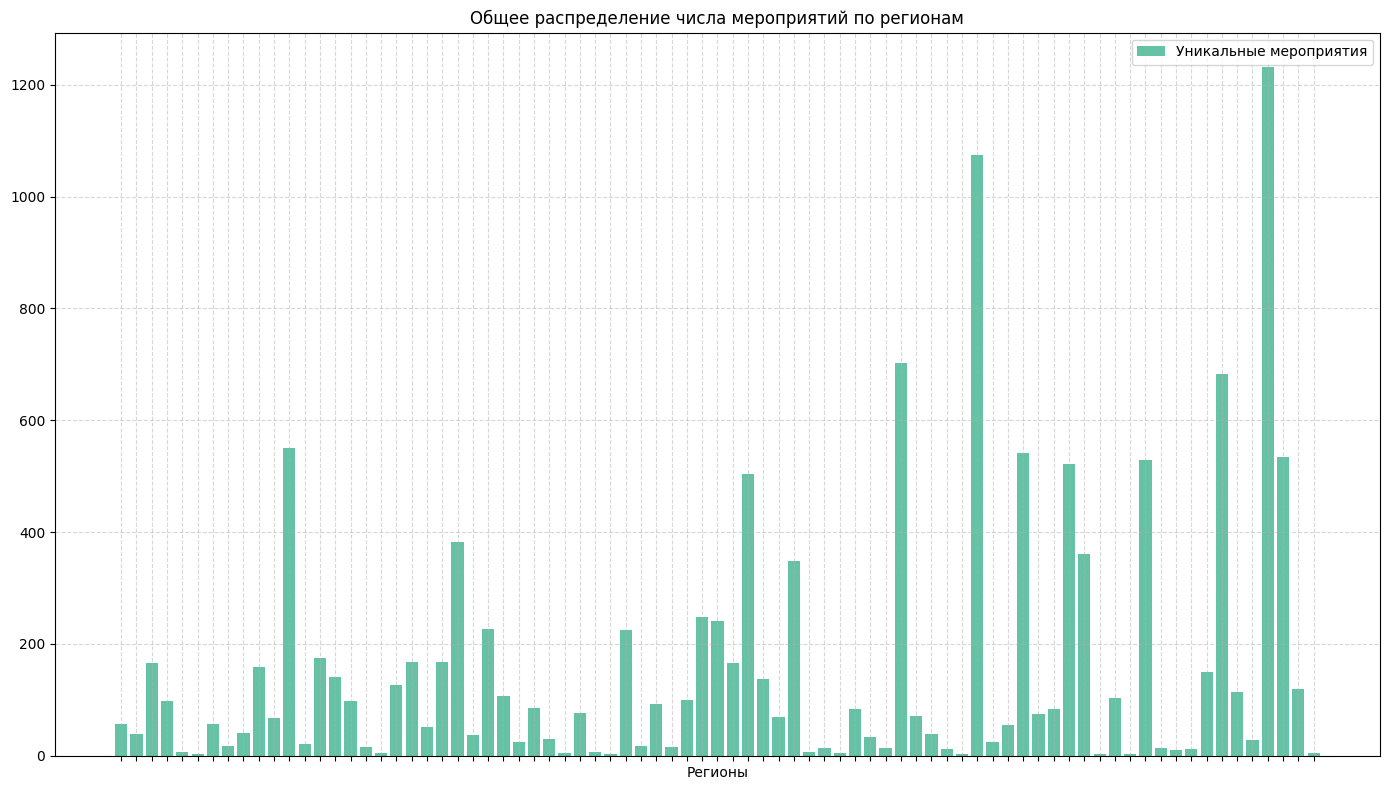

In [ ]:
df_region_all = df[~df['region_name'].isin(['Каменевский регион', 'Североярская область'])].groupby('region_name')['event_id'].nunique()
plt.figure(figsize = (14,8))
ax = plt.gca()
ax.bar(df_region_all.index, df_region_all.values, label = 'Уникальные мероприятия', color = color_palette(0), linewidth=2)
plt.title('Общее распределение числа мероприятий по регионам')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Регионы')
plt.legend(loc='upper right')
ax.tick_params(axis='x', labelbottom=False)
plt.tight_layout()
plt.show()

Общее распределение показывает не совсем стабильную динамику,среди регионов встречаются как очень небольшие по количеству мероприятий, так и более крупные показатели, при этом, диаграмма составлена без учета двух лидирующих регионов

Рассмотрим далее топ-10 по количеству заказов среди всех регионов

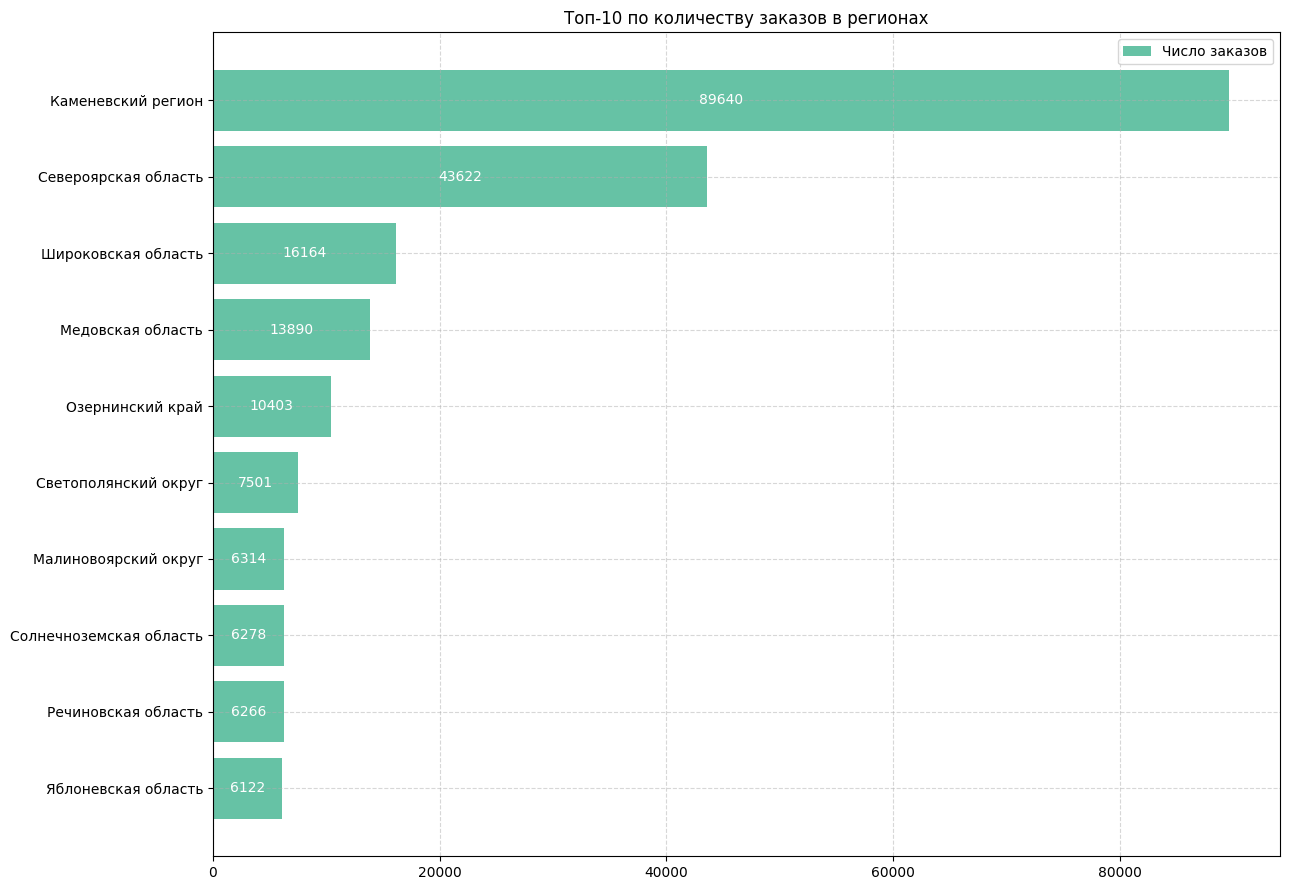

In [ ]:
df_region_group = df.groupby('region_name')['order_id'].nunique().sort_values(ascending=False).head(10)
plt.figure(figsize = (13,9))
ax = plt.gca()
ax.barh(df_region_group.index, df_region_group.values, label = 'Число заказов', color = color_palette(0), linewidth=2)
plt.title('Топ-10 по количеству заказов в регионах')
plt.grid(True, linestyle='--', alpha=0.5)
ax.bar_label(ax.containers[0], label_type='center', fontsize=10, color='white')
ax.invert_yaxis()
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Самыми активными по количеству заказов являются Каменевский регион и Североярская область, которые также занимают ведущие позиции по ассортименту и разнообразию проводимых мероприятий

Рассмотрим этот показатель так-же в относительном выражении

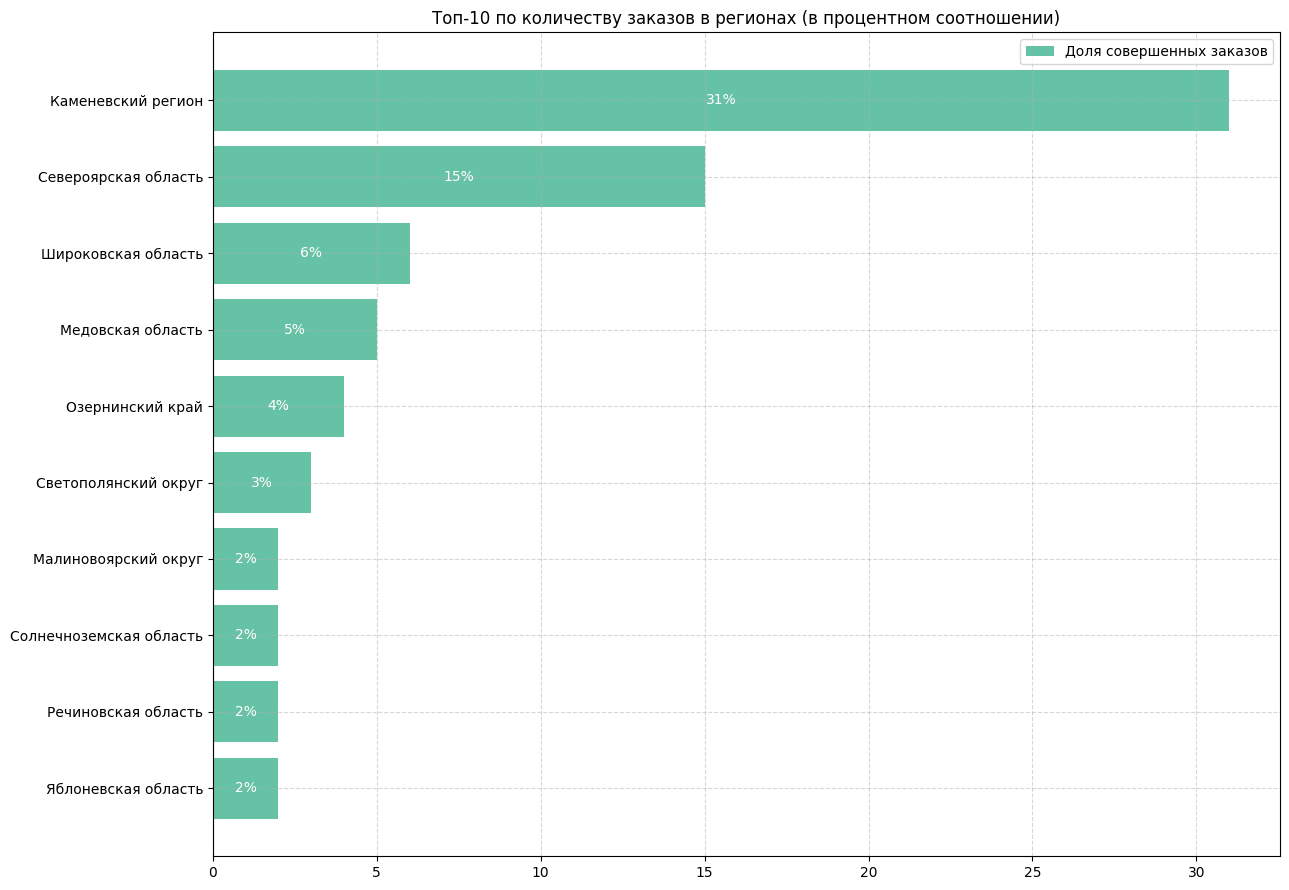

In [ ]:
df_share = df.groupby('region_name')['order_id'].nunique().sum()
df_region_group = round(df.groupby('region_name')['order_id'].nunique().sort_values(ascending=False).head(10) / df_share,2) * 100
plt.figure(figsize = (13,9))
ax = plt.gca()
ax.barh(df_region_group.index, df_region_group.values, label = 'Доля совершенных заказов', color = color_palette(0), linewidth=2)
plt.title('Топ-10 по количеству заказов в регионах (в процентном соотношении)')
plt.grid(True, linestyle='--', alpha=0.5)
ax.bar_label(
    ax.containers[0],
    labels=df_region_group.values.round(0).astype(int).astype(str) + '%',
    label_type='center', fontsize=10, color='white')
ax.invert_yaxis()
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Каменевский регион и Североярская область занимают более 47% от общего числа заказов а также 44% от всех проводимых мероприятий

Рассмотрим также динамику всех остальных регионов по этому показателю, предварительно отсеев лидирующие регионы

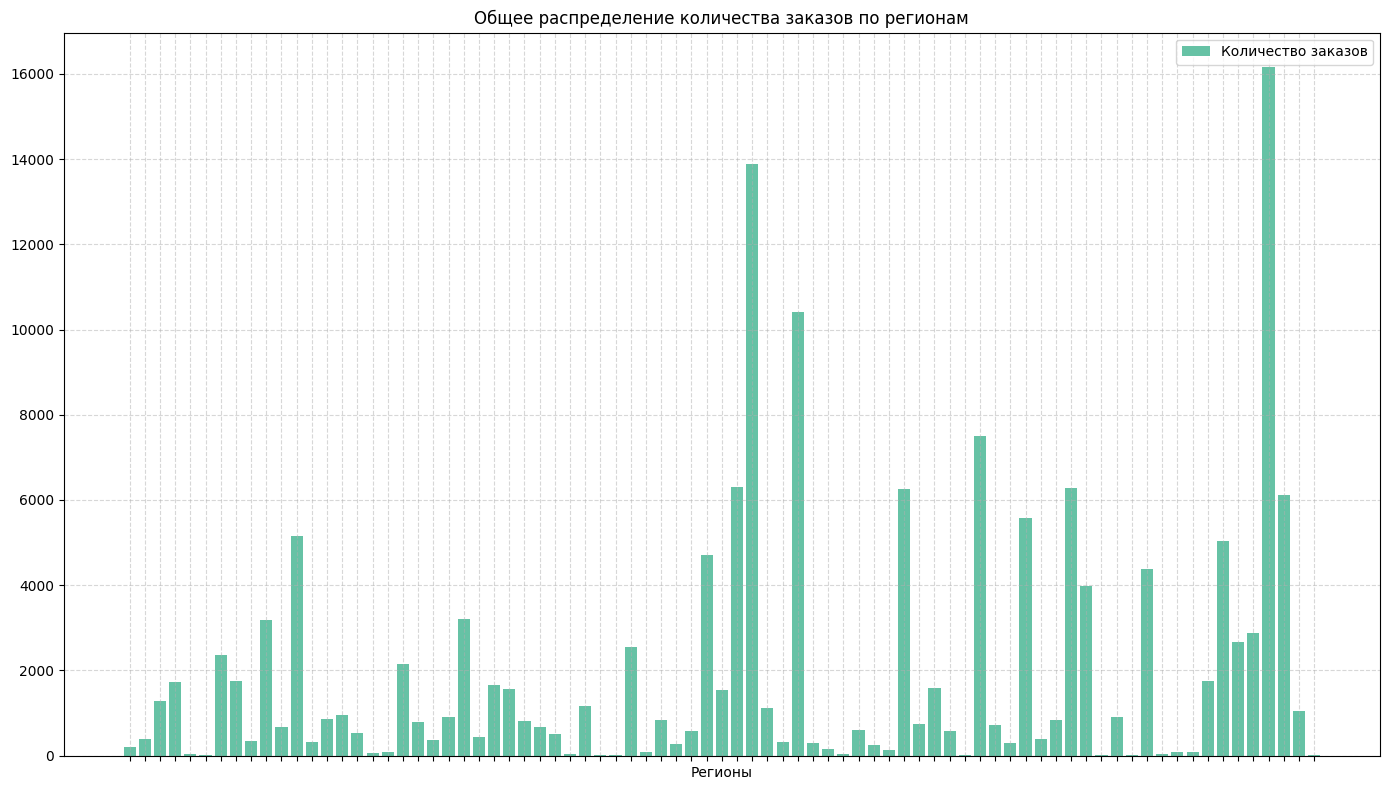

In [ ]:
df_region_all = df[~df['region_name'].isin(['Каменевский регион', 'Североярская область'])].groupby('region_name')['order_id'].nunique()
plt.figure(figsize = (14,8))
ax = plt.gca()
ax.bar(df_region_all.index, df_region_all.values, label = 'Количество заказов', color = color_palette(0), linewidth=2)
plt.title('Общее распределение количества заказов по регионам')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Регионы')
plt.legend(loc='upper right')
ax.tick_params(axis='x', labelbottom=False)
plt.tight_layout()
plt.show()

Представленный график распределения количества заказов по регионам практически полностью совпадает с графиком распределения общего числа проводимых мероприятий. Это указывает на сильную корреляцию между активностью по заказам и насыщенностью мероприятий в этих регионах

Далее мы изучим организаторов мероприятий, посчитаем общее число уникальных мероприятий, количество заказов а также суммарную выручку.

Сфокусируемся на наиболее активных партнёрах

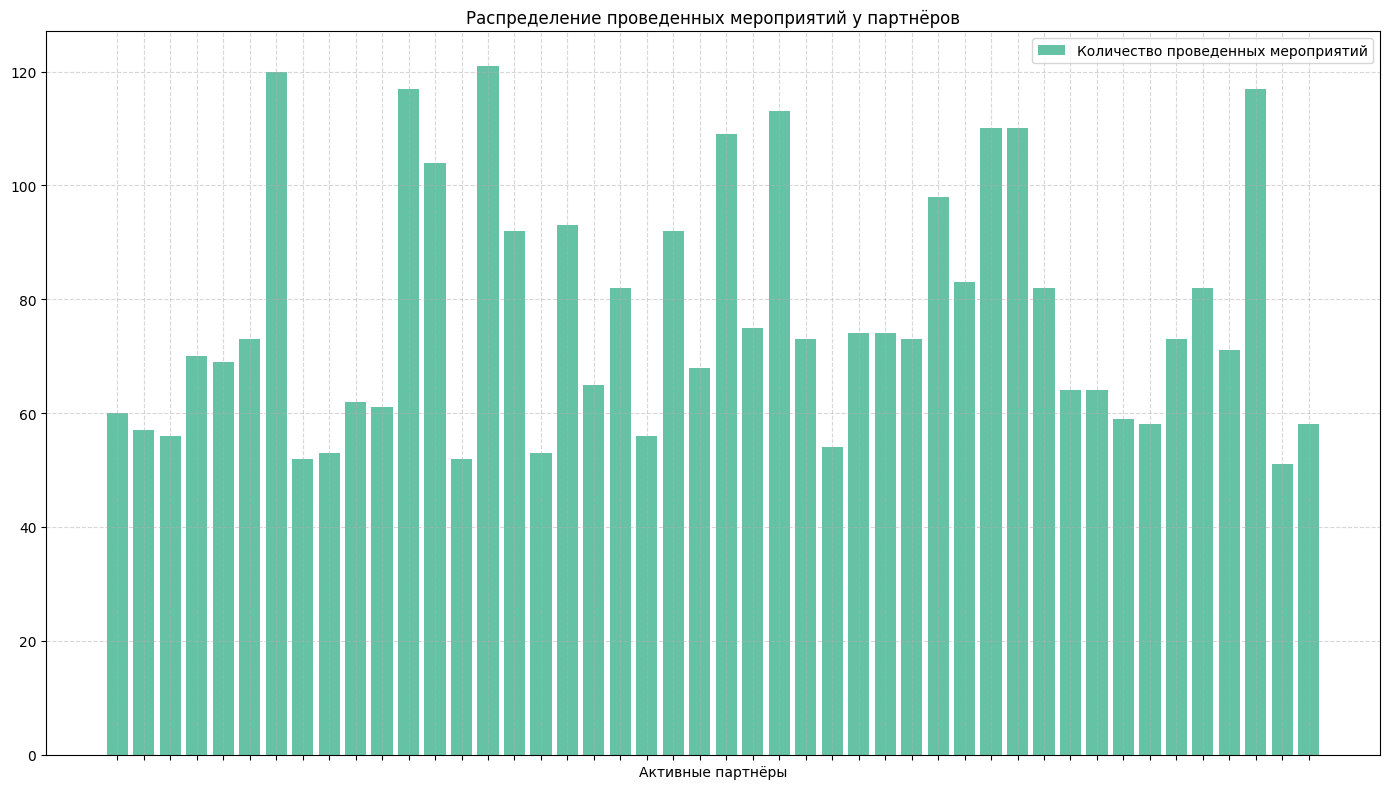

In [ ]:
# Активного партнёра будем считать того, у кого на счету более 50 проведенных мероприятий
df_parthers_event = df.groupby('organizers')['event_id'].nunique()
df_parthers_event = df_parthers_event[df_parthers_event > 50]
plt.figure(figsize = (14,8))
ax = plt.gca()
ax.bar(df_parthers_event.index, df_parthers_event.values, label = 'Количество проведенных мероприятий', color = color_palette(0), linewidth=2)
plt.title('Распределение проведенных мероприятий у партнёров')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Активные партнёры')
plt.legend(loc='upper right')
ax.tick_params(axis='x', labelbottom=False)
plt.tight_layout()
plt.show()

Общее число проведенных мероприятий у организаторов показывает устойчивую динамику, при этом лишь несколько организаторов существенно выделяются на фоне остальных. В целом, активность организаторов сохраняется на стабильном уровне
Рассмотрим отдельно лидирующих организаторов
Далее мы рассмотрим общее количество заказов, выполненных нашими партнёрами

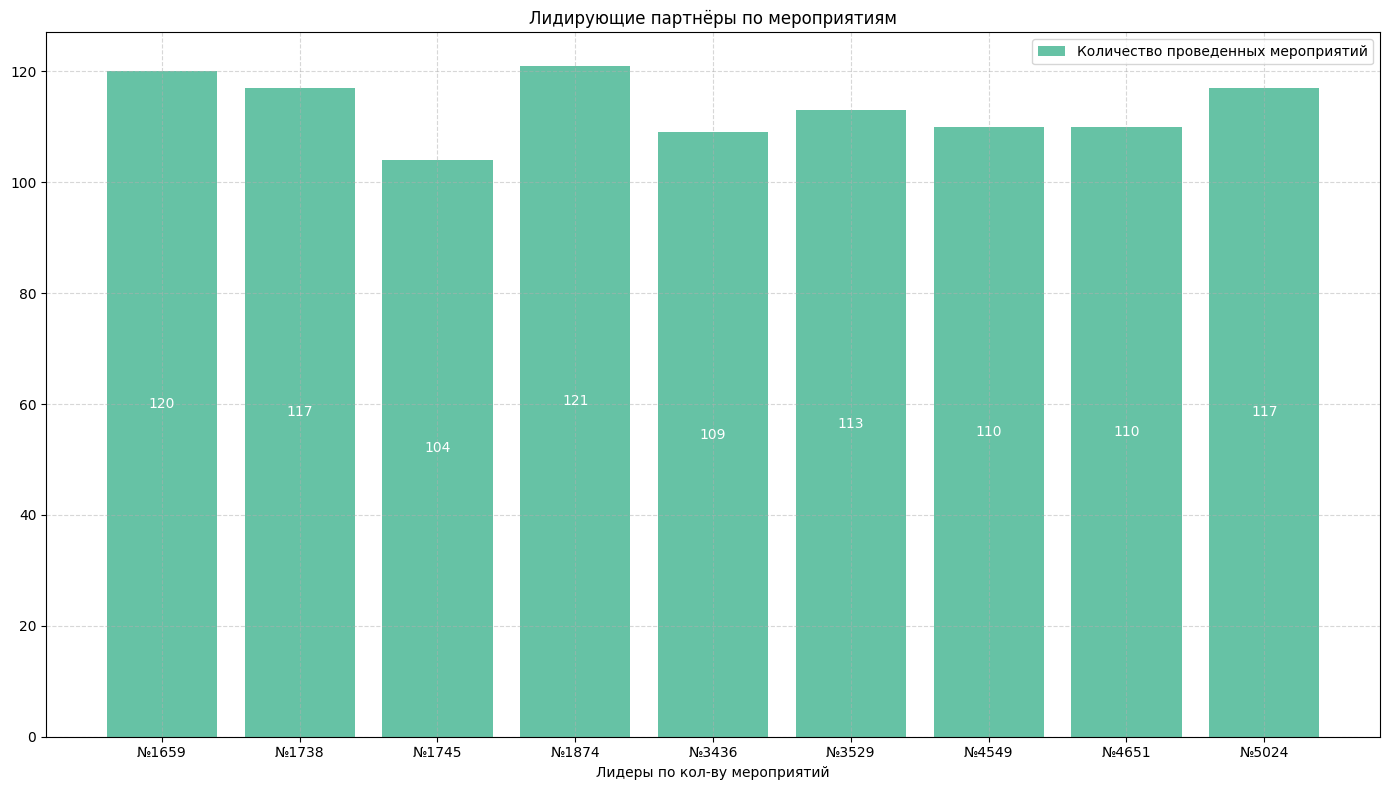

In [ ]:
df_parthers_event = df.groupby('organizers')['event_id'].nunique()
df_parthers_event = df_parthers_event[df_parthers_event > 100]
plt.figure(figsize = (14,8))
ax = plt.gca()
ax.bar(df_parthers_event.index, df_parthers_event.values, label = 'Количество проведенных мероприятий', color = color_palette(0), linewidth=2)
plt.title('Лидирующие партнёры по мероприятиям')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Лидеры по кол-ву мероприятий')
ax.bar_label(ax.containers[0], label_type='center', fontsize=10, color='white')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Всего лидируют девять организаторов, показывающих самые высокие показатели по количеству проведённых мероприятий

Далее мы рассмотрим общее количество заказов, выполненных нашими партнёрами

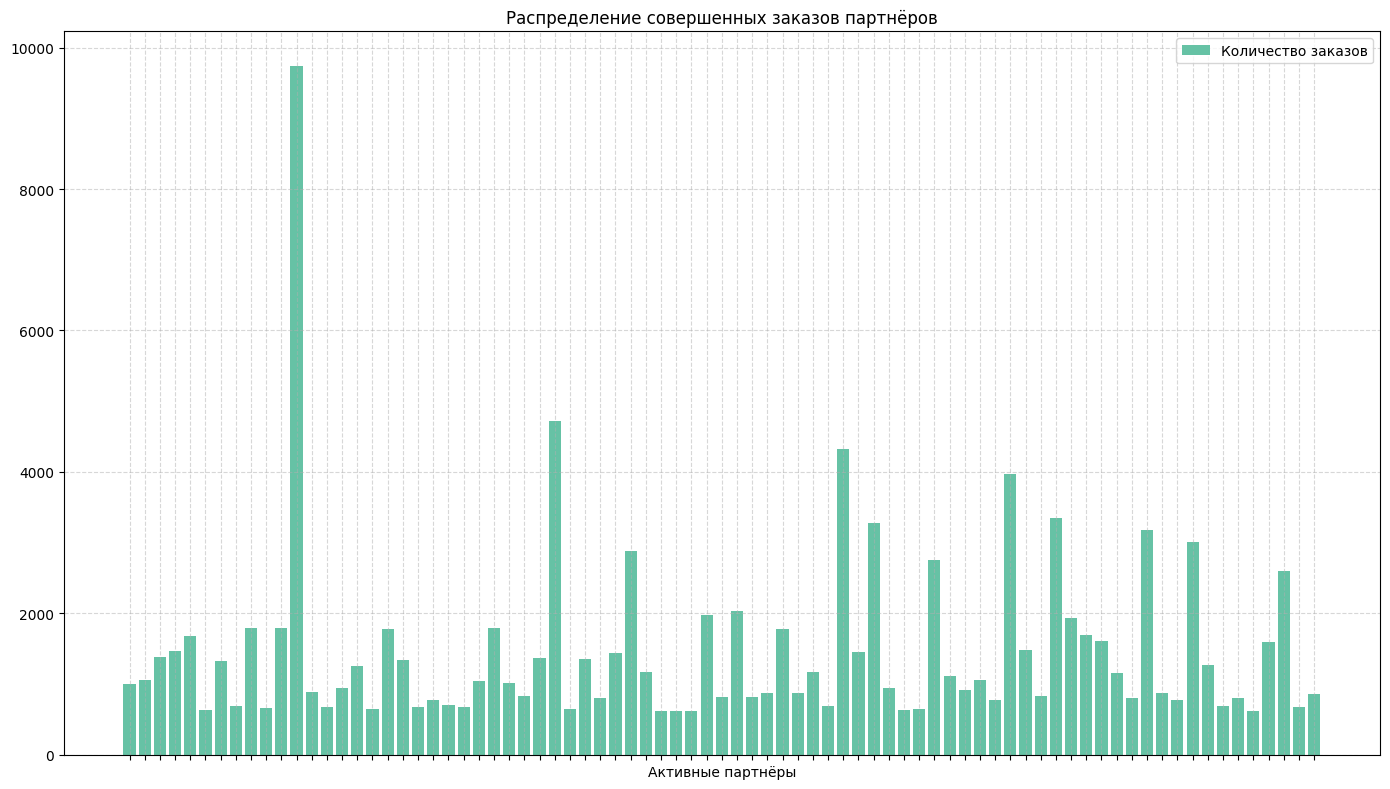

In [ ]:
df_parthers_order = df.groupby('organizers')['order_id'].nunique()
# Рассматривать будем тех партнёров, у которых число заказов переваливает за 600
df_parthers_order = df_parthers_order[df_parthers_order > 600]
plt.figure(figsize = (14,8))
ax = plt.gca()
ax.bar(df_parthers_order.index, df_parthers_order.values, label = 'Количество заказов', color = color_palette(0), linewidth=2)
plt.title('Распределение совершенных заказов партнёров')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Активные партнёры')
plt.legend(loc='upper right')
ax.tick_params(axis='x', labelbottom=False)
plt.tight_layout()
plt.show()

Распределение заказов партнёров показывает стабильную тенденцию: у большинства из них число заказов не превышает 2000. При этом выделяются лидеры по продажам билетов, которых мы более подробно рассмотрим в следующей диаграмме.

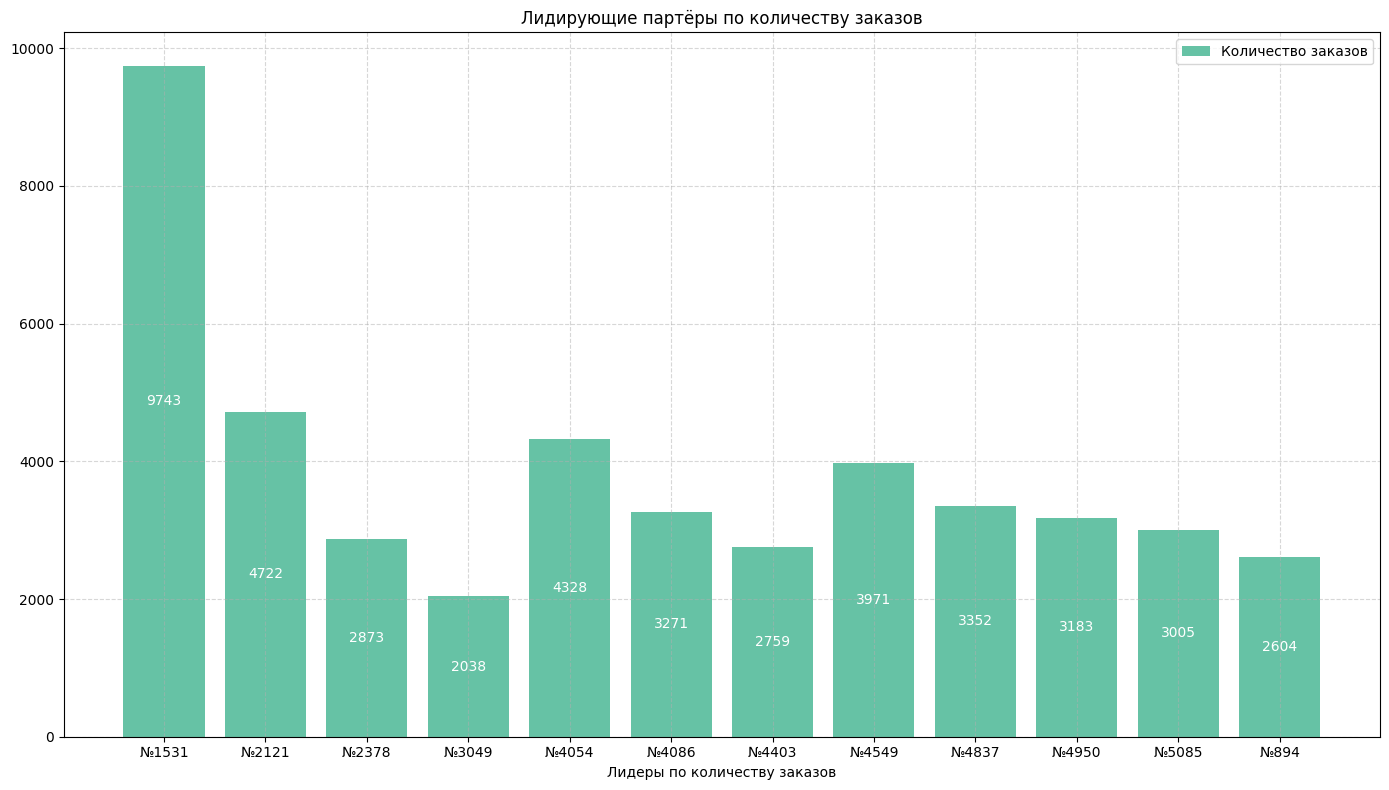

In [ ]:
df_parthers_order = df_parthers_order[df_parthers_order > 2000]
plt.figure(figsize = (14,8))
ax = plt.gca()
ax.bar(df_parthers_order.index, df_parthers_order.values, label = 'Количество заказов', color = color_palette(0), linewidth=2)
plt.title('Лидирующие партёры по количеству заказов')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Лидеры по количеству заказов')
ax.bar_label(ax.containers[0], label_type='center', fontsize=10, color='white')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


Самым лидирующим организатором является партнёр № 1531, показавший впечатляющий результат — продажа 9 743 заказов. В то время как у остальных партнёров число заказов пребывает в среднем 3 500
Далее мы рассмотрим распределение суммарной выручки с заказов билетов, и выявим наиболее прибыльных партнёров

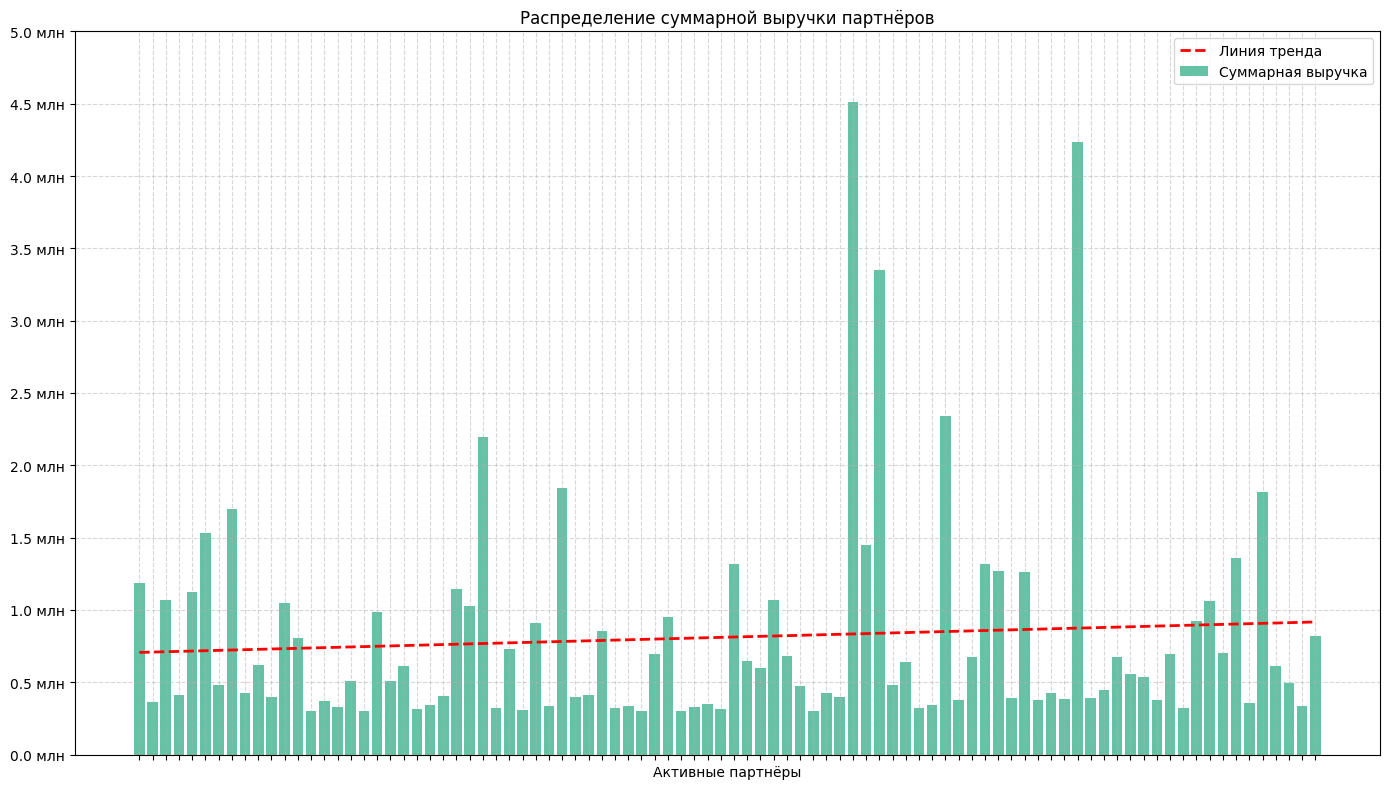

In [ ]:
# Рассматриваем тех партнёров, чья суммарная выручка больше 300 000
df_revenue_parthers = df.groupby('organizers')['revenue_rub'].sum()
df_revenue_parthers = df_revenue_parthers[df_revenue_parthers > 300000]
def million_format(x, pos):
    return f'{x/1_000_000:.1f} млн'
plt.figure(figsize=(14,8))
ax = plt.gca()
ax.bar(df_revenue_parthers.index, df_revenue_parthers.values, label='Суммарная выручка', color=color_palette(0), linewidth=2)
plt.title('Распределение суммарной выручки партнёров')
plt.grid(True, linestyle='--', alpha=0.5)
x = np.arange(len(df_revenue_parthers))
y = df_revenue_parthers.values
coeffs = np.polyfit(x, y, deg=1)
trend = np.poly1d(coeffs)
ax.plot(df_revenue_parthers.index, trend(x), color='red', linewidth=2, label='Линия тренда', linestyle='--')
plt.xlabel('Активные партнёры')
plt.ylim(0, 5000000)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(million_format))
ax.set_yticks(range(0, 5000001, 500000))
plt.legend(loc='upper right')
ax.tick_params(axis='x', labelbottom=False)
plt.tight_layout()
plt.show()

У большинства активных партнёров суммарная выручка составляет примерно 500 000 рублей, при этом, на графике также заметны партнеры с значительно более высокой выручкой — свыше 1,5 миллиона рублей, их мы выделим отдельно, кроме того, по линии тренда можно заметить, что суммарная выручка постепенно, пусть и незначительно, но увеличивается  

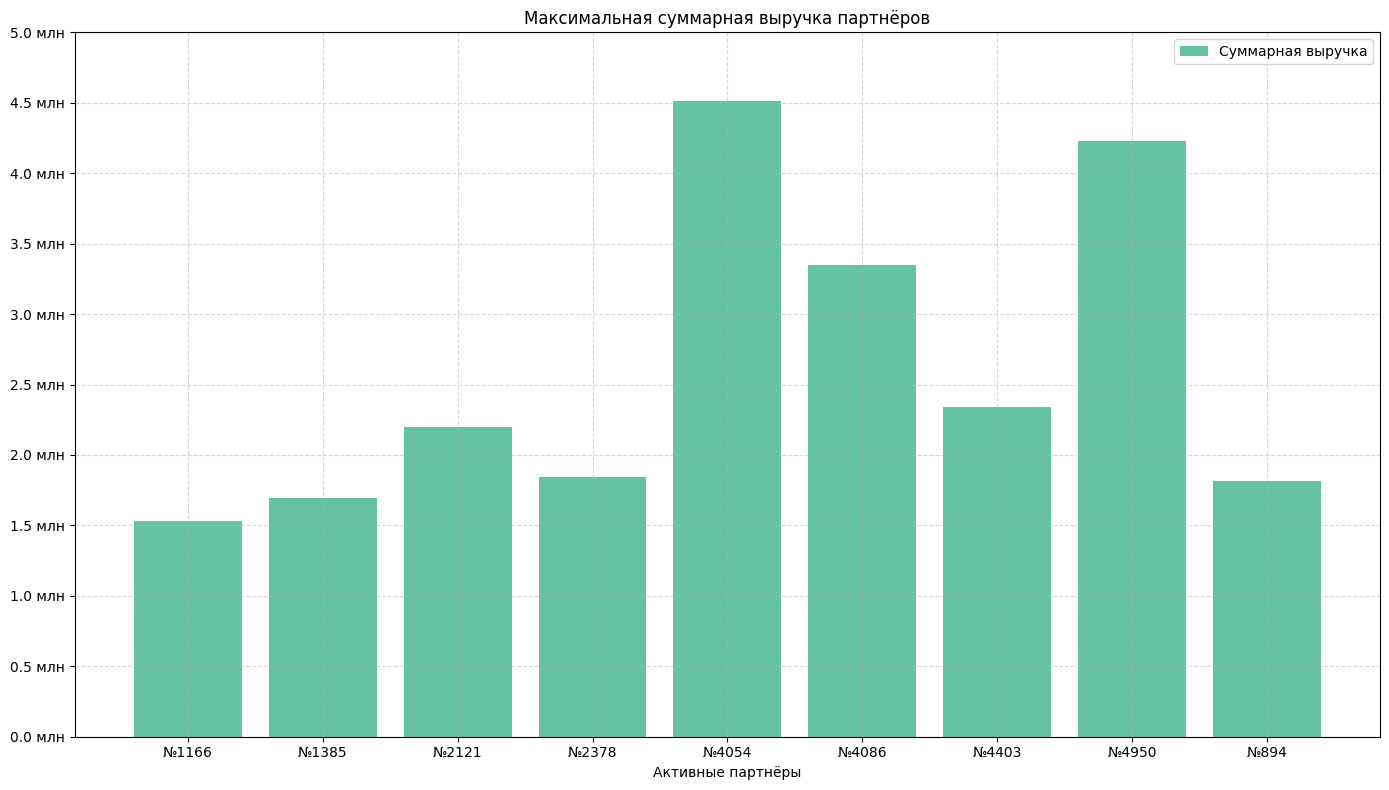

In [ ]:
df_revenue_parthers = df_revenue_parthers[df_revenue_parthers > 1500000]
def million_format(x, pos):
    return f'{x/1_000_000:.1f} млн'
plt.figure(figsize=(14,8))
ax = plt.gca()
ax.bar(df_revenue_parthers.index, df_revenue_parthers.values, label='Суммарная выручка', color=color_palette(0), linewidth=2)
plt.title('Максимальная суммарная выручка партнёров')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Активные партнёры')
plt.ylim(0, 5000000)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(million_format))
ax.set_yticks(range(0, 5000001, 500000))
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Промежуточный вывод по анализу мероприятий и партнёров
- Динамика продаж и разнообразия мероприятий в регионах остается достаточно нестабильной. Среди них выделяются два лидера — Каменевский регион и Североярская область, которые занимают примерно половину как по объему продаж билетов, так и по ассортименту предлагаемых мероприятий. В то же время, в ряде регионов мероприятия проходят крайне редко, и их популярность в этих местах остается низкой
- При анализе организаторов мы сосредоточились на наиболее активных участниках
- Динамика проведенных мероприятий у партнёров демонстрирует стабильность: среди них есть лидеры с более чем 100 проведёнными событиями.
- Число заказов у большинства партнёров колеблется около 1300, но есть и лидеры с более чем 3500 заказами. Особого внимания заслуживает организатор № 1531, осуществивший рекордные 9743 заказа — это самое большое количество зафиксированных в системе
- Распределение суммарной выручки показывает как стабильную динамику, так и наличие рекордных значений. Восемь организаторов заработали более 1,5 миллиона рублей, также стоит отметить организатора №4054, достигшего рекордной выручки свыше 4,5 миллиона рублей

## 4. Статистический анализ данных

####4.1. Проверим две гипотезы относительно активности пользователей мобильных и стационарных устройств, предполагающие большую активность пользователей мобильных устройств:
- Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств
- Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств

Использовать данные будем только за осенний период

Сформулируем для первой гипотезы "`Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств`" нулевую и альтернативную формулировку
- Нулевая гипотеза: "`Среднее количество заказов на одного пользователя мобильного приложения не различается по сравнению с пользователями стационарных устройств`"
- Альтернативная гипотеза: "`Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств`"

In [ ]:
df.groupby('user_id')['order_id'].count().describe()

,order_id
count,21836.000000
mean,13.169628
std,121.562638
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,10166.000000


####Так как в наших данных имеется большое количество выбросов, то для проверки двух гипотез наиболее подходящий статистический тест является U-тест Манна-Уитни, так как он не требователен к выборкам, а также устойчив к выбросам

In [ ]:

df_mobile = df_fall.query("device_type_canonical == 'mobile'")
df_desktop = df_fall.query("device_type_canonical == 'desktop'")
# Проверка на пересечение данных
set_mobile = set(df_fall.query("device_type_canonical == 'mobile'")['user_id'])
set_desktop = set(df_fall.query("device_type_canonical == 'desktop'")['user_id'])
all_set = set_mobile & set_desktop
df_mobile = df_mobile.query("user_id not in @all_set")
df_desktop = df_desktop.query("user_id not in @all_set")
mobile = df_mobile.groupby('user_id')['order_id'].count()
desktop = df_desktop.groupby('user_id')['order_id'].count()
alpha = 0.05
manna_utni_test = mannwhitneyu(
    mobile,
    desktop,
    alternative='greater' # выбираем одностороннюю гипотезу
                            # alternative='greater' соответствует альтернативной гипотезе: mobile > desktop
)
if manna_utni_test.pvalue > alpha:
    print(f'pvalue = {manna_utni_test.pvalue}')
    print('Нулевая гипотеза подтверждается, среднее количество заказов на одного пользователя мобильного приложения не отличается по сравнению с пользователями стационарных устройств')
else:
    print(f'pvalue = {manna_utni_test.pvalue}')
    print('Принимаем альтернативную гипотезу, среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств')

pvalue = 4.061440740037343e-39
Принимаем альтернативную гипотезу, среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств


Альтернативная версия для первой гипотезы подтвердилась: среднее количество заказов на одного пользователя мобильного приложения действительно превышает показатель у пользователей стационарных устройств

В ходе предыдущих этапов анализа мы уже отмечали, что доля активности покупателей через мобильное приложение значительно выше, чем у пользователей с десктопных устройств

Теперь же это наблюдение было подтверждено на статистическом уровне

Далее проверим вторую гипотезу "`Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств`"
и сформулируем для нее нулевую и альтернативную версию
- Нулевая гипотеза: "`Среднее время между заказами пользователей мобильных приложений не отличается по сравнению с пользователями стационарных устройств`"
- Альтернативная гипотеза: "`Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств`"

In [ ]:

df_mobile_time = df_fall.query("device_type_canonical == 'mobile'")
df_desktop_time = df_fall.query("device_type_canonical == 'desktop'")
# Проверка на пересечение данных
set_mobile_time = set(df_fall.query("device_type_canonical == 'mobile'")['user_id'])
set_desktop_time = set(df_fall.query("device_type_canonical == 'desktop'")['user_id'])
all_set = set_mobile_time & set_desktop_time
df_mobile_time = df_mobile_time.query("user_id not in @all_set")
df_desktop_time = df_desktop_time.query("user_id not in @all_set")
mobile_time = df_mobile_time.groupby('user_id')['days_since_prev'].count()
desktop_time = df_desktop_time.groupby('user_id')['days_since_prev'].count()
manna_utni_test_time = mannwhitneyu(
    mobile_time,
    desktop_time,
    alternative='greater' # выбираем одностороннюю гипотезу
                            # alternative='greater' соответствует альтернативной гипотезе: mobile_time > desktop_time
)
if manna_utni_test_time.pvalue > alpha:
    print(f'pvalue = {manna_utni_test_time.pvalue}')
    print('Нулевая гипотеза подтверждается, среднее время между заказами пользователей мобильных приложений не отличается по сравнению с пользователями стационарных устройств')
else:
    print(f'pvalue = {manna_utni_test_time.pvalue}')
    print('Принимаем альтернативную гипотезу, среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств')

pvalue = 1.773992644252969e-33
Принимаем альтернативную гипотезу, среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств


Также для второй гипотезы подтверждена её альтернативная версия: среднее время между заказами у пользователей мобильного приложения больше чем у пользователей с десктопных устройств. Таким образом, на основе полученных данных можно сделать два статистических вывода:

- Среднее количество заказов на одного пользователя мобильного приложения выше, чем у пользователей стационарных устройств.
- Среднее время между заказами у пользователей мобильного приложения также больше, чем у пользователей с десктопных устройств.

---

## 5. Общий вывод и рекомендации
- В ходе анализа использовались таблицы:
 - `order_df` — содержит информацию о всех заказах билетов, совершённых с мобильных и стационарных устройств
 - `event_df` — включает данные о мероприятиях, такие как город и регион проведения
 - `tenge_df` — предоставляет информацию о курсах валют за 2024 год
- Эти таблицы были объединены в единый датафрейм `df`. После этого он был тщательно проверен на наличие ошибок, аномалий, пропусков и дубликатов. Проведённая подготовка позволила полностью подготовить данные для дальнейших этапов исследовательского анализа.
- Осенью активность покупателей выросла благодаря масштабным концертам. Особенно это проявилось 3 сентября и 1 октября, когда прошли крупнейшие концерты, а снижение цен и акции помогли привлечь широкую аудиторию.
- Анализ показал, что большинство пользователей совершают покупки со смартфона — это подтверждается статистическими тестами.
- Также было выявлено, что среднее время между заказами у пользователей мобильного приложения выше, чем у тех, кто использует десктопные устройства.
- Среди популярных мероприятий осенью лидируют «Театры» и спортивные события, однако концерты и выставки продолжают удерживать высокие позиции по популярности.
- В осенний сезон вырос интерес к детским мероприятиям с возрастными рейтингами 0+ и 12+.
- Средний чек остаётся на уровне примерно 175 рублей и постепенно увеличивается.
- Наиболее активными днями недели являются будние — именно в эти дни наблюдается наибольшее количество заказов, тогда как в выходные активность снижается
- По регионам лидирующие позиции занимают «Каменевский регион» и «Североярская область», которые вместе обеспечивают более 45% заказов и проведённых мероприятий
- Общая выручка партнёров стабильна и постепенно растёт со временем. Среди них встречаются лидеры, заработавшие более 1,5 миллиона рублей.
###Рекомендации
- Необходимо обратить внимание на низкую долю заказов с десктопных устройств, для этого рекомендуется запуск маркетинговых кампаний, ориентированных на стационарные устройства, чтобы увеличить их долю
- Анализ соотношения выручки в осенний и летний сезоны показывает снижение доходов даже по популярным мероприятиям, таким как концерты, театры и спортивные мероприятия, следует пересмотреть ценовую политику и выяснить причины этого снижения
- Важно организовать дополнительные маркетинговые кампании для привлечения пользователей в выходные дни, чтобы повысить их активность и расширить аудиторию